# DSFB 2019 Project - Team 3: Solutions

Team members:
![image.png](attachment:image.png)

## IMPORTS

Here are a bunch of libraries that you may need to use...

In [1]:
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC, SVR
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# for text processing
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, LsiModel, HdpModel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

# Additional imports
import string
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from gensim.models import LdaModel, LdaMulticore, LsiModel, HdpModel
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier

from IPython.display import display

# Special Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Useful function definitions

In [2]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()
    
def print_feature_importance(tree_model, feature_names):
    """
    Function to print a list of features from an sklearn tree model (ranked by importance of the feature)
    
    Args:
        tree_model       A sklearn DecisionTreeClassifier()
        feature_names    A list of features used by the DecisionTreeClassifier
    """
    print('Feature'.center(12), '   ',  'Importance')
    print('=' * 30)
    for index in reversed(np.argsort(tree_model.feature_importances_)):
        print(str(feature_names[index]).center(12) , '   ', '{0:.4f}'.format(tree_model.feature_importances_[index]).center(8)) 
        
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto', eta='auto', random_state=SEED)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((coherencemodel.get_coherence(), num_topics))
        print(f"Number of topics : {num_topics}, Coherence score : {coherence_values[-1][0]:.3f}")

    return model_list, coherence_values        

In [3]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False):
    
    plt.title('Validation Curve')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    
    train_scores_mean = train_scores#np.mean(train_scores, axis=1)
    cv_scores_mean    = cv_scores#np.mean(cv_scores,    axis=1)
    
    if x_logscale:
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean,    'o-', color="g",  label="Cross-validation score")        
    else:
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean,    'o-', color="g", label="Cross-validation score")
        
    plt.legend(loc='center')
    plt.show()

In [4]:
#custom_train_test_function(random_model, X_P1, y_P1)
def custom_train_test_function(model, X, y, name="model", test_size=0.2, proba=False, plot_train_score=False, test_req=True):
    # Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,  random_state=SEED)
    
    print(f"{'='*15}...Fitting the {name}...{'='*15}")
    model.fit(X_train, y_train)
    
    # Print model score and best parameters
    print("\nBest parameter (CV score - roc_auc=%0.3f):" % model.best_score_)
    print(model.best_params_)
    
    print(f"\n{'='*15}Training results with cross validation...{'='*15}\n")
    # Print train and test scores
    search_results = pd.DataFrame(model.cv_results_).filter(regex=("(test_score|train_score)"))
    display(search_results)
    
    # Plot a validation curve across levels of C, using a logscale for the x axis
    if plot_train_score:
        plot_validation_curve(search_results.mean_train_score.values, search_results.mean_test_score.values, search_results.index.values, x_logscale=False)

    if test_req:
        # Test the model and print relevent plots
        if proba:
            y_hat = model.predict_proba(X_test)[:, 1]
        else :
            y_hat = model.predict(X_test)

            print(f"\n{'='*15}Confusion matrix...{'='*15}\n")
            confusion_mat = confusion_matrix(y_test, y_hat)  
            plot_confusion_matrix(confusion_mat)
            plt.show()

            # Calculate accuracy
            accuracy = 1 - ((confusion_mat[0][1] + confusion_mat[1][0])/(confusion_mat[0][1] + confusion_mat[1][0] + confusion_mat[1][1] + confusion_mat[0][0]))
            print('Accuracy = ', "{0:.4f}".format(accuracy))

        print(f"\n{'='*15}ROC curve on the Test data ...{'='*15}\n")
        #plot roc curve
        fpr, tpr, _ = roc_curve(y_test, y_hat)
        best_auc = roc_auc_score(y_test, y_hat)
        plot_roc(fpr, tpr, f'ROC Curve for {name}', 'AUC = %2.4f' % best_auc)
    
    return model.best_estimator_

def custom_test_function(model, X_test, y_test, proba=False, name="model"):
    # Test the model and print relevent plots
    if proba:
        y_hat = model.predict_proba(X_test)[:, 1]
    else :
        y_hat = model.predict(X_test)

        print(f"\n{'='*15}Confusion matrix...{'='*15}\n")
        confusion_mat = confusion_matrix(y_test, y_hat)  
        plot_confusion_matrix(confusion_mat)
        plt.show()

        # Calculate accuracy
        accuracy = 1 - ((confusion_mat[0][1] + confusion_mat[1][0])/(confusion_mat[0][1] + confusion_mat[1][0] + confusion_mat[1][1] + confusion_mat[0][0]))
        print('Accuracy = ', "{0:.4f}".format(accuracy))

    print(f"\n{'='*15}ROC curve on the Test data ...{'='*15}\n")
    #plot roc curve
    fpr, tpr, _ = roc_curve(y_test, y_hat)
    best_auc = roc_auc_score(y_test, y_hat)
    plot_roc(fpr, tpr, f'ROC Curve for {name}', 'AUC = %2.4f' % best_auc)
    plt.show()

In [5]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx")
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [6]:
df_learn.shape

(3330, 47)

**Load data**: We notice that the first column in the data has unique ID, not an useful feature for prediction.

In [7]:
len(set(df_learn[df_learn.columns[0]].to_list()))

3330

Reload the data with first column as index

In [8]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx", index_col=0)
df_predict=pd.read_excel("IPO_data_to_predict.xlsx", index_col=0)

# Quick look at the data and observations

In [9]:
df_learn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3330 entries, 974 to 1741
Data columns (total 46 columns):
closeDay1             3215 non-null float64
offerPrice            3330 non-null float64
rf                    3057 non-null object
egc                   3330 non-null bool
html                  3330 non-null bool
patRatio              2055 non-null float64
city                  3329 non-null object
issuer                3330 non-null object
highTech              3330 non-null bool
age                   3148 non-null float64
exchange              3330 non-null object
year                  3330 non-null int64
industryFF5           3330 non-null object
industryFF12          3330 non-null object
industryFF48          3330 non-null object
nUnderwriters         3330 non-null int64
sharesOfferedPerc     3068 non-null float64
totalProceeds         3330 non-null int64
manager               3330 non-null object
investmentReceived    1830 non-null float64
amountOnProspectus    3330 non-nul

**Comments**: We observe that there 46 columns out of which 38 are numeric/bool and 8 are text type. We also notice that there are some missing data in many fields. 

Now we look at the detailed profile of the dataFrame using pandas profiling. (The report is provided in HTML along with the submission. Observations related to the report are given below).

In [10]:
#file.profile_report()
#profile = pandas_profiling.ProfileReport(df_learn)
#profile.to_file(outputfile='learn_data_profile_report.html')

**Observations from the profile report**

* Presence of missing values (Either drop or process the missig fileds)
* High correlation among 5 fields (May be ignored or Use PCA to reduce the dimentionality)
* Different scales, ranging from 0 to 1e9. (Need to normalize the data)
* Missing outcome: offerPrice(3.5%) and closeDay1(3.5%). Since there is no outcome, it may not be useful to use this data, may be dropped.
* Only 22% of the companies are marked emerging growth companies. (Possibility of bias?)
* Most of the companies are listed in NASDAQ(2368), followed by NYSE(895)
* Data is present from 1996 to 2018 (More data in the late 90s, but data is well spread across years)
* Five fields that are skewed (totalProceeds, InvestmentReceived, commonEquity1, totalRevenue, nPatents)
* 19 fileds out of 47 have missing entries. Highest missing entries in investmentReceived(45%) followed by nExecutives, priorFinancing, nVCs, patRatio, managementFee(32.9%) in descending order

In [10]:
# Profile report for the prediction data
#profile = pandas_profiling.ProfileReport(df_predict)
#profile.to_file(outputfile='predict_data_profile_report.html')

In [11]:
data = copy.copy(df_learn)

We do exploratory analysis of the data and missing fields in the cells below

Missing data dristribution across various fields is shown below

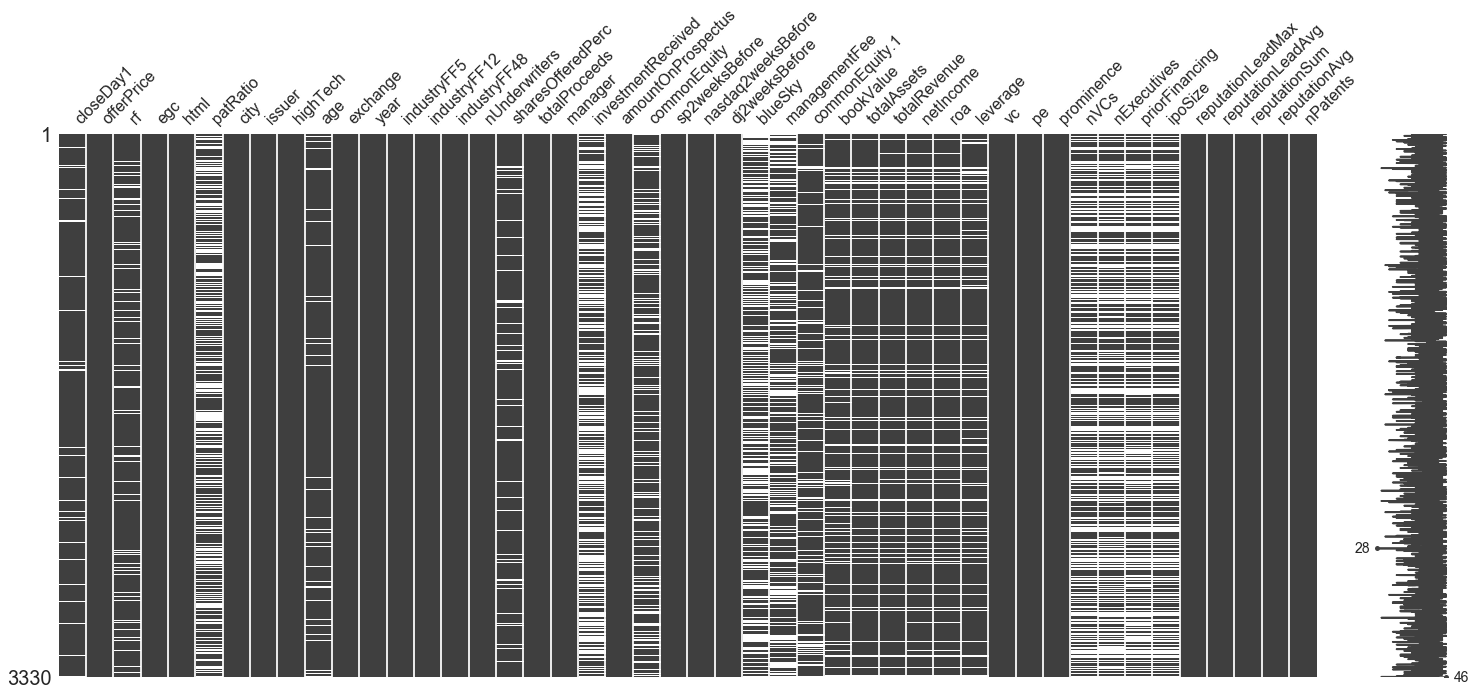

In [12]:
msno.matrix(data)

**Comment** : Write what the following cell does

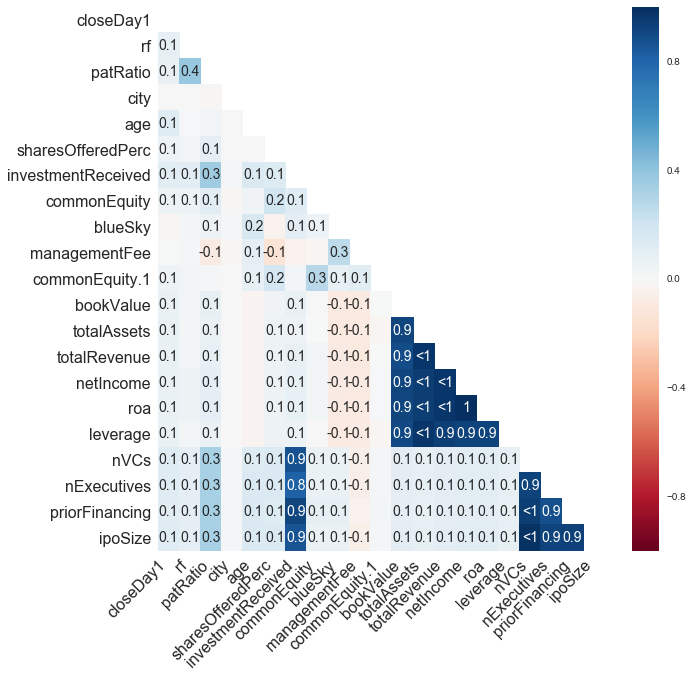

In [13]:
incomplete = data.columns[data.isnull().any()].tolist()
msno.heatmap(data[incomplete], figsize=(10,10))

**Comment**: The following cell shows the correlation among the datafields.

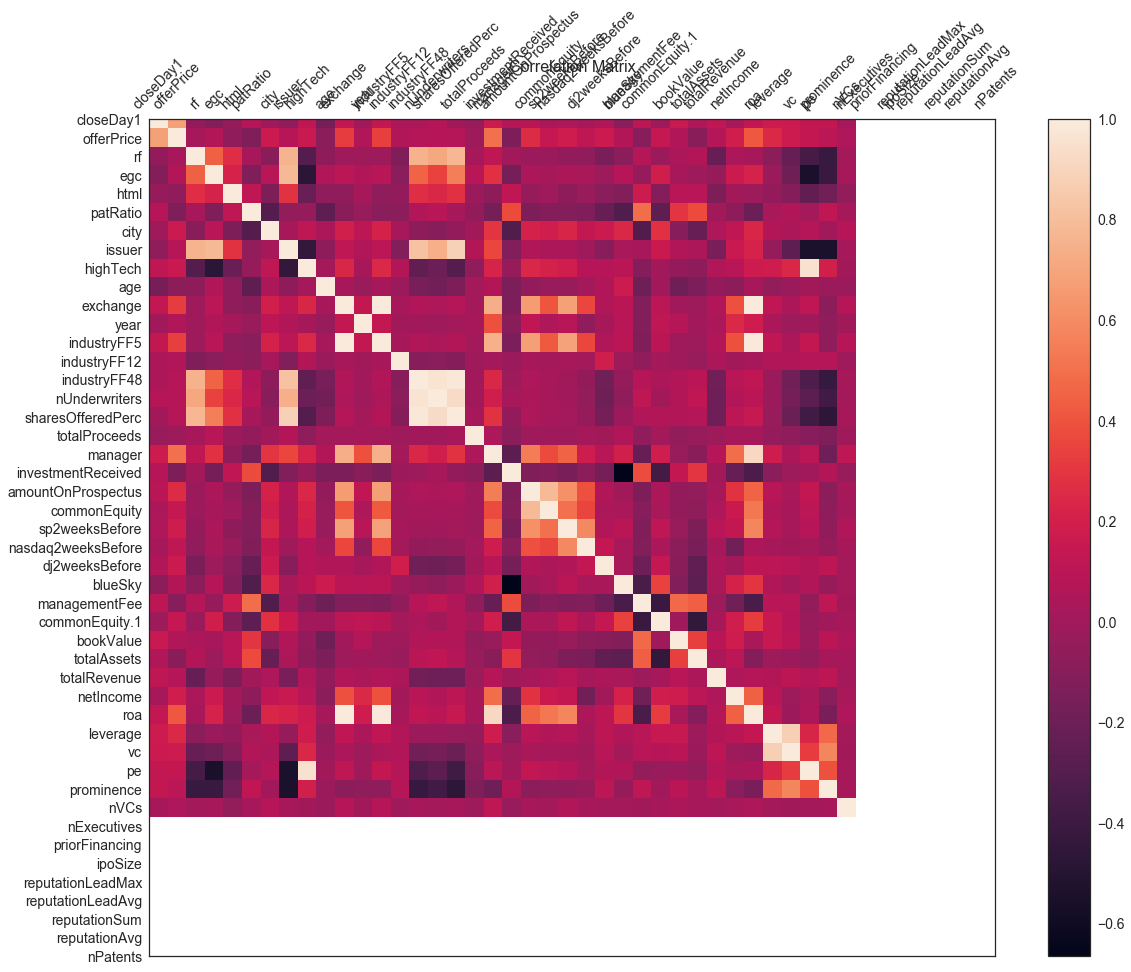

In [14]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Observations**: We notice that most of the fields are weakly correlated. However, there are few features that has strong positive and negative correlations.

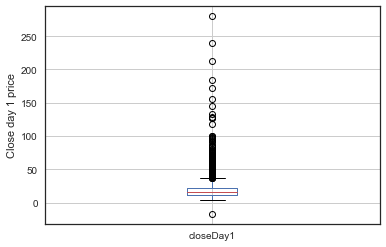

In [15]:
# Distribution of the Close day 1
data.boxplot(column='closeDay1')
plt.ylabel('Close day 1 price')
plt.show()

In [16]:
df_learn['exchange'].value_counts()

NASDQ    2368
NYSE      895
AMEX       67
Name: exchange, dtype: int64

In [17]:
df_learn['industryFF5'].value_counts()

Business Equipment, Telephone and Television Transmission                                         1122
Other                                                                                              898
Healthcare, Medical Equipment, and Drugs                                                           621
Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)     393
Manufacturing, Energy, and Utilities                                                               296
Name: industryFF5, dtype: int64

In [18]:
df_learn['industryFF12'].value_counts().head()

Business Equipment -- Computers, Software, and Electronic Equipment    945
Healthcare, Medical Equipment, and Drugs                               621
Finance                                                                483
Other                                                                  462
Wholesale, Retail, and Some Services (Laundries, Repair Shops)         271
Name: industryFF12, dtype: int64

In [19]:
df_learn['industryFF48'].value_counts().head()

Business Services          845
Pharmaceutical Products    409
Trading                    221
Electronic Equipment       190
Retail                     158
Name: industryFF48, dtype: int64

**Comments**: Will probably need to only keep 1 of these, maybe FF12?


In [20]:
df_learn = df_learn.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

**Comments**: Age is the age of the firm. Should replace mising values by the mean? Are the zeros indicating new firms?

In [21]:
print(df_learn['age'].mean())
print(df_learn['age'].mode())

16.184561626429478
0    3.0
dtype: float64


In [22]:
len([w for w in df_learn['age'] if w>100])

53

**Comments**: Is it possible to have so much old companies?

In [23]:
print(df_learn['blueSky'].median(), df_learn['blueSky'].mean())

10000.0 12916.115884115885


**Comments**: Should do something with *blue sky* missing value: need to decide if really useful and, if it is, how to fill it. mean, median or mean between 1sr and 3rd quarter

# Part 1: data cleaning and preprocessing


In [75]:
processed_data = copy.deepcopy(df_learn)

## Part 1A : Replacing the null fields
**Comment**: In the following cells, we replace or drop the null fields using appropriate logic for that perticular field

In [76]:
processed_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [77]:
processed_data['age'].fillna(processed_data['age'].median(), inplace=True)

In [78]:
processed_data['blueSky'].fillna(processed_data['blueSky'].median(), inplace=True)

We decide to drop the data corresponding to missing or negative values of 'closeDay1' as this feature is very important and so replacing missing values may lead to huge misinterpretation. Moreover it corresponds to only 3.5% of the data


In [79]:
processed_data.dropna(subset=["closeDay1"], inplace=True)

**Comment** : We fill the null "Risk factor" field with ""

In [80]:
processed_data.rf.fillna("", inplace=True)

In [81]:
processed_data['patRatio'].fillna(processed_data['patRatio'].median(), inplace=True)

In [82]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "priorFinancing", "ipoSize"]

In [83]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.0,NaN,924417.0,100.00,219.134116,240.974,23.34,-48.811,-0.202557,0.000000,64190.0,68114956.0
2585,17.09,NaN,0.063,NaN,40.99,231.418979,2190.648,142.89,15.918,0.007266,0.155445,NaN,NaN


In [84]:
processed_data[replace_mean] = processed_data[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [85]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.000000,-0.879771,9.244170e+05,100.00,219.134116,240.974,23.34,-48.811,-0.202557,0.000000,64190.00000,6.811496e+07
2585,17.09,172172.815261,0.063000,2.069941e+06,40.99,231.418979,2190.648,142.89,15.918,0.007266,0.155445,130854.10542,1.453785e+08


In [86]:
replace_median = ["nExecutives", "nVCs"]

In [87]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,NaN,NaN


In [88]:
processed_data[replace_median] = processed_data[replace_median].apply(lambda x: x.fillna(x.median()),axis=0)

In [89]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,11.0,6.0


In [90]:
processed_data.shape

(3215, 46)

#data.profile_report()

Referring to the profile report generated, attached as HTML along with submission.

We can see that some features are highly correlated, so we will use PCA to remove the redundant features.

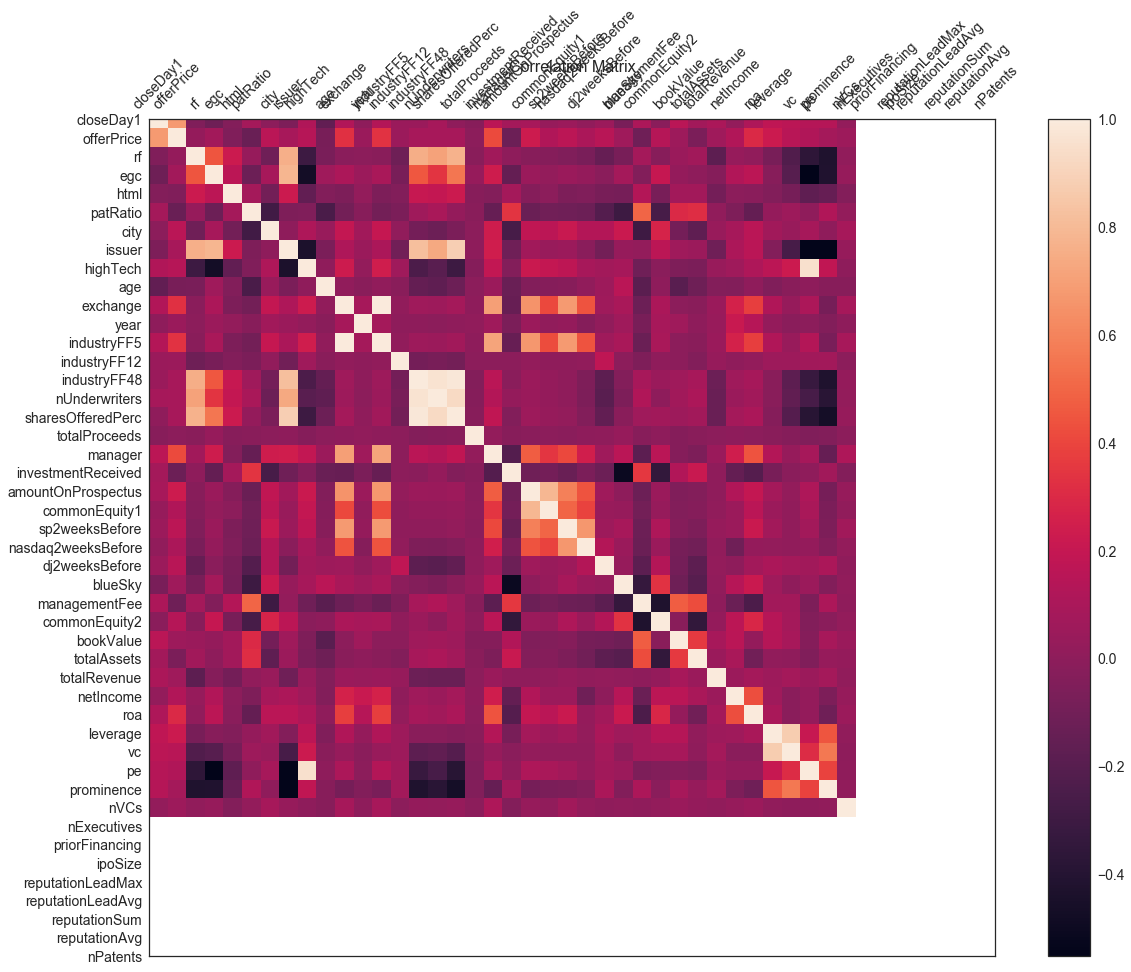

In [91]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(processed_data.corr(), fignum=f.number)
plt.xticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14, rotation=45)
plt.yticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The following cell shows that all the filed are pre-processed. Since there are no null fields. Also notice that the number of rows have reduced.

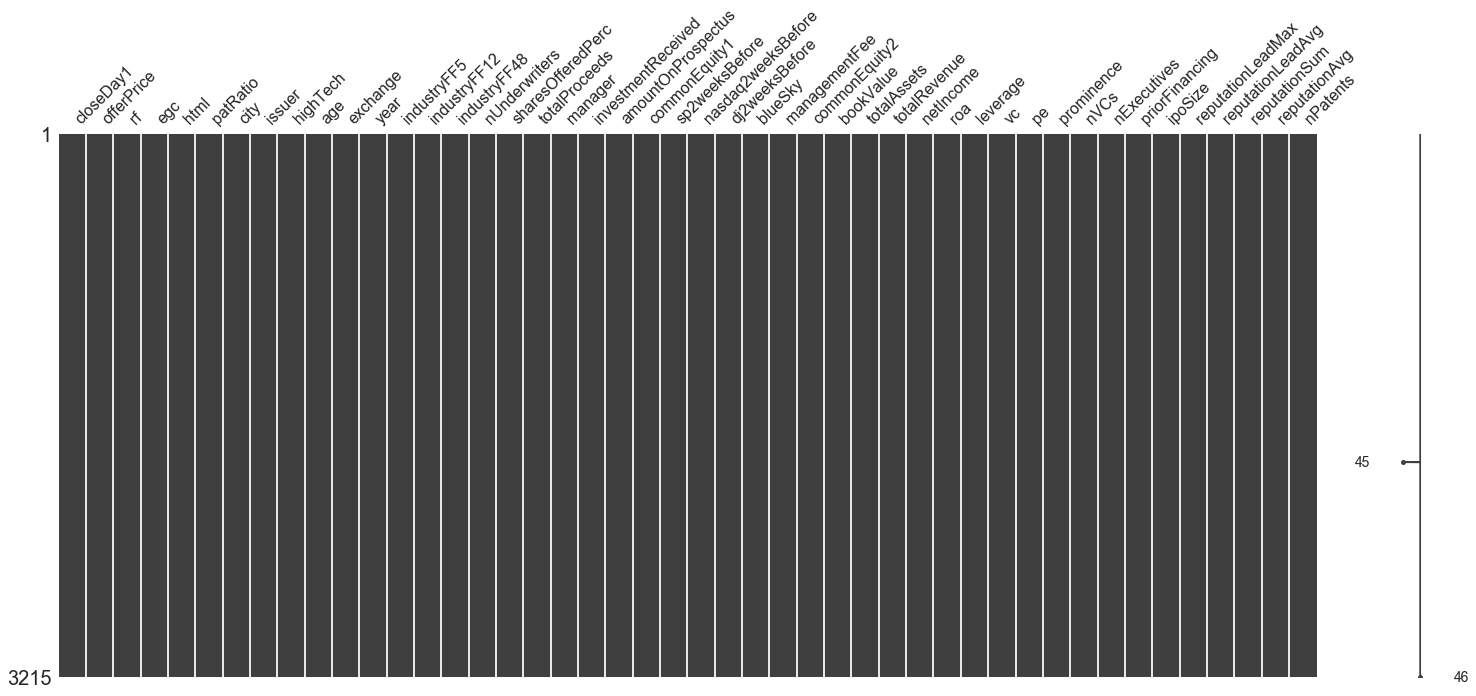

In [92]:
msno.matrix(processed_data)

## Part 1B: Processing the fields (Addition, deletion)

**Comments**

1. 'issuer' is unique, hence will not be a useful feature for prediction. We drop it from the list of useful features and set it as index.
2. 'Exchange' is categorical (3 distinct values). We create dummies
3. 'IndustryFF12' is also categorical (5 distinct values)
4. ['manager', 'city'] have high cardinality, hence dropped from the useful features
5. Update True/False fields to 1/0

In [93]:
# Unique field 'issuer' is made index of the cell
processed_data.set_index('issuer', drop=True, inplace=True)

In [94]:
processed_data = pd.get_dummies(data=processed_data, columns= ['exchange', 'industryFF12'])

In [95]:
processed_data.drop(['manager', 'city'], axis=1, inplace=True)

We have decided to drop city and manager as the cardinality of these data is very huge.

In [96]:
# Creating additional field for return and raisingPrice(upORdown)
processed_data['return'] = (processed_data['closeDay1'] - processed_data['offerPrice'])/(processed_data['offerPrice'] + 1e-10)
processed_data["raisingPrice"] = (processed_data["return"] > 0).astype(int)

In [97]:
processed_data[processed_data.select_dtypes([np.bool]).columns] = processed_data.select_dtypes([np.bool]).astype(int)

In [98]:
y = np.array(processed_data['raisingPrice'])

In [99]:
y.shape

(3215,)

In [100]:
processed_data.columns

Index(['closeDay1', 'offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech',
       'age', 'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
       'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
       'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
       'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
       'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
       'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
       'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
       'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
       'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
       'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
       'industryFF12_Chemicals and Allied Products',
       'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
       'industryFF12_Consumer NonDurables -- Food, Tobacco, Textile

In [101]:
#processed_data = processed_data.head(200)

## Part 1C: Text pre-process on Risk Factor

In [102]:
# Get English Stopwords from NLTK & Extend the stop word list
stop_words = stopwords.words('english')
stop_words.extend(['risk', 'factor', 'company', 'stock', 'may', 'inc', 'co', 'result', 'financial', \
               'portfolio', 'business', 'market', 'customer', 'service', 'price', 'management', \
              'product', 'operation', 'adversely', 'new', 'revenue', 'sale', 'operating', \
                   'adverse', 'effect', 'consider', 'careful', 'need', 'cost', 'information', 'investment', \
                   'fact', 'carefully', 'following', 'common'
              ])


In [103]:
print(len(stop_words), stop_words[:10])
''.join(stop_words).__contains__('could')

214 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


True

In [104]:
#looks how many percent of risk facor are NaN values
processed_data['rf'].isna().sum()/len(processed_data['rf'])

0.0

In [105]:
#file them with a blank
processed_data['rf'] = processed_data['rf'].fillna('')

In [106]:
# Define a custom function to clean some given text
def clean_re(txt):
    txt = re.sub(f"[{string.punctuation}]", "", str(txt))
    
    return txt

In [107]:
# Test clean_re
txt = "akjdf!!@#$%^&*()_/*965214"
clean_re(txt)

'akjdf965214'

In [108]:
# Apply clean_re() to all features
processed_data['rf'] = processed_data['rf'].apply(clean_re)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       RISK FACTORS You should carefully consider the...
Home BancShares Inc,Conway,AR    risk factors an investment in our common stock...
Name: rf, dtype: object

In [109]:
wnl=nltk.stem.WordNetLemmatizer()

def lemmatize_text(txt):
    return ' '.join([wnl.lemmatize(t.lower()) for t in txt.split(' ')])

In [110]:
# Apply lemmatize_text() to all features  
processed_data['rf'] = processed_data['rf'].apply(lemmatize_text)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       risk factor you should carefully consider the ...
Home BancShares Inc,Conway,AR    risk factor an investment in our common stock ...
Name: rf, dtype: object

In [111]:
#lnl=nltk.stem.LancasterStemmer()

#def lemmatize_text_lnl(txt):
#    return ' '.join([lnl.stem(t.lower()) for t in txt.split(' ')])

In [112]:
# Apply lemmatize_text() to all features  
#processed_data['rf'] = processed_data['rf'].apply(lemmatize_text_lnl)    
#processed_data['rf'].head(2)

In [113]:
# Define custom function to remove stopwords
def clean_stopwords(txt):
    li = list(txt.lower().split(" "))
    txt = [word for word in li if word not in stop_words]
    return ' '.join(txt)

#pattern = re.compile(r'(?i)\b(' + r'|'.join(stop_words) + r')\b\s*')
#def clean_stopwords(txt):
#    txt = pattern.sub('', txt)
#    return txt 

In [114]:
# Test clean_stopwords
txt = " ".join(stop_words).lower()
print("**All stop words**:", txt)
clean_stopwords(txt)

**All stop words**: i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't risk factor company stock may inc co result 

''

In [115]:
# Apply function to remove stopwords
processed_data['rf'] = processed_data['rf'].apply(clean_stopwords)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       contained prospectus purchasing key within sem...
Home BancShares Inc,Conway,AR    involves making decision described together co...
Name: rf, dtype: object

In [116]:
# Define custom function to wrap simple_preprocess() from gensim
#def sp(txt):
#    return simple_preprocess(txt)

# Define custom function to wrap simple_preprocess() from gensim
def wrap_simple_preprocess(txt):
    return simple_preprocess(str(txt))

In [117]:
# Apply simple_preprocess() to all features
processed_data['rf'] = processed_data['rf'].apply(wrap_simple_preprocess)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       [contained, prospectus, purchasing, key, withi...
Home BancShares Inc,Conway,AR    [involves, making, decision, described, togeth...
Name: rf, dtype: object

# Part 2: Feature extraction

Choose most relevant features for each of the model and justification

Logit : Baseline : Linear :Knn:Kmeans :SVC:Decision trees:Random forests:Splines:

## Part 2A: Extracting features from 'rf'

In this section, we utilize NLP to process risk factors and extract useful features for prediction.
Reference: [web link](https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html)

In [118]:
#processed_data = processed_data

### Topic models

We try various topic models (LSI, HDA, LDA) and select one of them based on the coherence score.

In [119]:
id2word = corpora.Dictionary(processed_data['rf'])
corpus = [id2word.doc2bow(doc) for doc in processed_data['rf']]

In [120]:
no_topics = 9
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word, num_topics=no_topics, random_state=SEED,
)

In [121]:
cm_lda = CoherenceModel(model=lda_model, texts=processed_data["rf"], dictionary=id2word)
print(f"Coherence score : {cm_lda.get_coherence():.3f}")

Coherence score : 0.317


In [122]:
#lda_models, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_data.rf, start=1, limit=15, step=2)

In [123]:
#coherence_values = np.array(coherence_values)

In [124]:
#index_selected = np.argmax(coherence_values[:,0])
#no_topics_selected = coherence_values[index_selected,1]
#no_topics_selected

In [125]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word, num_topics=9, alpha='auto', eta='auto', random_state=SEED)

In [123]:
# Visualize topics-keywords
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

Creating other NLP models to process 'risk factor' text

In [124]:
#lsi_model = LsiModel(corpus=corpus, num_topics=no_topics_selected, id2word=id2word)

In [125]:
#hdp_model = HdpModel(corpus=corpus, id2word=id2word)

In [126]:
#texts = processed_data.rf
#lda_coherence = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word).get_coherence()
#lsi_coherence = CoherenceModel(model=lsi_model, texts=texts, dictionary=id2word).get_coherence()
#hdp_coherence = CoherenceModel(model=hdp_model, texts=texts, dictionary=id2word).get_coherence()

In [127]:
#df_coherence = pd.DataFrame({'LDA':[lda_coherence], 'LSI':[lsi_coherence], 'HDP':[hdp_coherence]})
#df_coherence.T.plot.bar()
#plt.ylabel("Coherence score")
#df_coherence

In [128]:
# Visualize topics-keywords
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(hdp_model, corpus, id2word)
#vis

### Extracting feature vector for each observation

In [126]:
#selected_rf_model = hdp_model.suggested_lda_model()
selected_topic_model = lda_model

In [127]:
rows = processed_data.rf.shape[0]
rows

3215

In [128]:
features_rf = []
no_topics_selected = 9
for i in range(rows):
    top_topics = selected_topic_model.get_document_topics(corpus[i], minimum_probability=0.0)
    #top_topics = hdp_model.evaluate_test_corpus([corpus[i]])
    topic_vec = [top_topics[i][1] for i in range(int(no_topics_selected))]
    #topic_vec.extend([len(processed_data["rf"].iloc[i])])
    #topic_vec.extend([len(''.join(processed_data["rf"].iloc[i]))]) # length review
    features_rf.append(topic_vec)

In [129]:
df_rf_features = pd.DataFrame(features_rf, columns=range(int(no_topics_selected)), index=processed_data.rf.index).add_prefix('rf_')
pd.concat([df_rf_features, df_rf_features.sum(axis=1)], axis=1).head(3)

,rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8,0
issuer,,,,,,,,,,
Numerical Technologies Inc,0.646629,0.000104,0.000110,0.347292,0.005409,0.000117,0.000119,0.000119,0.000101,1.0
"Home BancShares Inc,Conway,AR",0.005285,0.000108,0.000112,0.000130,0.000121,0.000122,0.094196,0.000868,0.899056,1.0
Boise Cascade Co,0.000141,0.000101,0.000104,0.000132,0.005750,0.000739,0.942903,0.020339,0.029792,1.0


In [130]:
#lsi_model = LsiModel(corpus=corpus, num_topics=25, id2word=id2word)
#lsi_model.show_topics(num_topics=3)

In [131]:
#lsi_topics = lsi_model.show_topics(formatted=False)

# Part 2: processing of the data to predict

In [ ]:
df_predict.shape

# Part 3: Feature extraction

Extract features and targets from the processed_data

In [132]:
# Select targets 
#y_data_labels = ['closeDay1', 'offerPrice', 'return', 'raisingPrice']
#Y_data = processed_data[y_data_labels]

#X_data = processed_data.drop(y_data_labels, axis=1)
#Y_data.columns, X_data.columns

(Index(['closeDay1', 'offerPrice', 'return', 'raisingPrice'], dtype='object'),
 Index(['rf', 'egc', 'html', 'patRatio', 'highTech', 'age', 'year',
        'industryFF5', 'industryFF48', 'nUnderwriters', 'sharesOfferedPerc',
        'totalProceeds', 'investmentReceived', 'amountOnProspectus',
        'commonEquity1', 'sp2weeksBefore', 'nasdaq2weeksBefore',
        'dj2weeksBefore', 'blueSky', 'managementFee', 'commonEquity2',
        'bookValue', 'totalAssets', 'totalRevenue', 'netIncome', 'roa',
        'leverage', 'vc', 'pe', 'prominence', 'nVCs', 'nExecutives',
        'priorFinancing', 'ipoSize', 'reputationLeadMax', 'reputationLeadAvg',
        'reputationSum', 'reputationAvg', 'nPatents', 'exchange_AMEX',
        'exchange_NASDQ', 'exchange_NYSE',
        'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
        'industryFF12_Chemicals and Allied Products',
        'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
  

In [182]:
# Select targets 
y_data_labels = ['closeDay1', 'return', 'raisingPrice']
Y_data = processed_data[y_data_labels]

X_data = processed_data.drop(y_data_labels, axis=1)
Y_data.columns, X_data.columns

(Index(['closeDay1', 'return', 'raisingPrice'], dtype='object'),
 Index(['offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech', 'age',
        'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
        'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
        'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
        'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
        'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
        'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
        'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
        'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
        'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
        'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
        'industryFF12_Chemicals and Allied Products',
        'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
  

In [183]:
Y_data.head(3)

,closeDay1,return,raisingPrice
issuer,,,
Numerical Technologies Inc,35.5625,1.540179,1
"Home BancShares Inc,Conway,AR",20.0000,0.111111,1
Boise Cascade Co,26.1500,0.245238,1


We drop the text fields 'rf', 'industryFF12', 'industryFF48' and add the extracted features using text analysis

In [184]:
X_data.drop(['rf', 'industryFF5', 'industryFF48'], axis=1, inplace=True)

In [185]:
X = pd.concat([X_data, df_rf_features], axis=1, sort=False)

In [186]:
X.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492063,1,5.0,2000,14,30.50,68114956,...,0,0.646629,0.000104,0.000110,0.347292,0.005409,0.000117,0.000119,0.000119,0.000101
"Home BancShares Inc,Conway,AR",18.0,0,1,0.447917,0,8.0,2006,4,17.09,45000000,...,0,0.005285,0.000108,0.000112,0.000130,0.000121,0.000122,0.094196,0.000868,0.899056


In [190]:
X.columns

Index(['offerPrice', 'egc', 'html', 'patRatio', 'highTech', 'age', 'year',
       'nUnderwriters', 'sharesOfferedPerc', 'totalProceeds',
       'investmentReceived', 'amountOnProspectus', 'commonEquity1',
       'sp2weeksBefore', 'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky',
       'managementFee', 'commonEquity2', 'bookValue', 'totalAssets',
       'totalRevenue', 'netIncome', 'roa', 'leverage', 'vc', 'pe',
       'prominence', 'nVCs', 'nExecutives', 'priorFinancing', 'ipoSize',
       'reputationLeadMax', 'reputationLeadAvg', 'reputationSum',
       'reputationAvg', 'nPatents', 'exchange_AMEX', 'exchange_NASDQ',
       'exchange_NYSE',
       'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
       'industryFF12_Chemicals and Allied Products',
       'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
       'industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys',
       'industryFF12_F

In [187]:
X_data.head(2)

,offerPrice,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,...,"industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances","industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys",industryFF12_Finance,"industryFF12_Healthcare, Medical Equipment, and Drugs","industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)"
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,14.0,0,0,0.492063,1,5.0,2000,14,30.50,68114956,...,0,0,0,0,0,0,0,0,0,0
"Home BancShares Inc,Conway,AR",18.0,0,1,0.447917,0,8.0,2006,4,17.09,45000000,...,0,0,1,0,0,0,0,0,0,0


In [191]:
X_P1, y_P1 = X_data, Y_data.raisingPrice

In [337]:
X_P2.columns

Index(['year',
       'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
       'industryFF12_Chemicals and Allied Products',
       'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
       'industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys',
       'industryFF12_Finance',
       'industryFF12_Healthcare, Medical Equipment, and Drugs',
       'industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing',
       'industryFF12_Oil, Gas, and Coal Extraction and Products',
       'industryFF12_Other',
       'industryFF12_Telephone and Television Transmission',
       'industryFF12_Utilities',
       'industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)',
       'rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7', 'rf_8'],
      dtype='object')

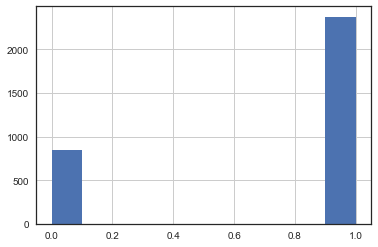

In [195]:
y_P1.hist()

In [196]:
X_P2, y_P2 = X.filter(regex=("(rf_*)|(FF12_*)|(year)")), Y_data.raisingPrice
X_P2.head(2)

,year,"industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment",industryFF12_Chemicals and Allied Products,"industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances","industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys",industryFF12_Finance,"industryFF12_Healthcare, Medical Equipment, and Drugs","industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,...,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,2000,1,0,0,0,0,0,0,0,0,...,0,0.646629,0.000104,0.000110,0.347292,0.005409,0.000117,0.000119,0.000119,0.000101
"Home BancShares Inc,Conway,AR",2006,0,0,0,0,1,0,0,0,0,...,0,0.005285,0.000108,0.000112,0.000130,0.000121,0.000122,0.094196,0.000868,0.899056


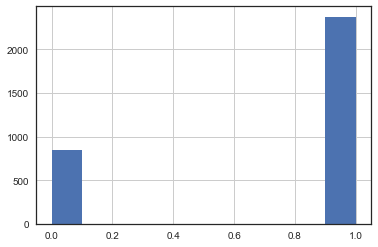

In [197]:
y_P2.hist()

In [198]:
X_P3, y_P3 = X, Y_data.raisingPrice

In [199]:
Y_data['return'].head(5)

issuer
Numerical Technologies Inc       1.540179
Home BancShares Inc,Conway,AR    0.111111
Boise Cascade Co                 0.245238
Latitude Communications Inc      0.151042
Syros Pharmaceuticals Inc        0.452000
Name: return, dtype: float64

In [200]:
X_P4, y_P4 = X, (Y_data['return'] > 0.20).astype('int')

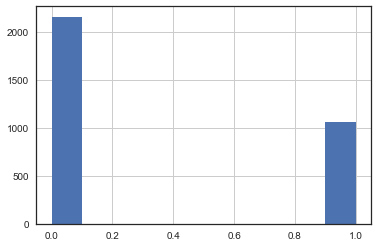

In [201]:
y_P4.hist()

In [202]:
X_P5, y_P5 = X, (Y_data['return'] < -0.20).astype('int')

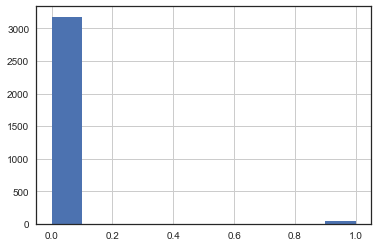

In [203]:
y_P5.hist()

In [204]:
X_P6, y_P6 = X, Y_data.closeDay1

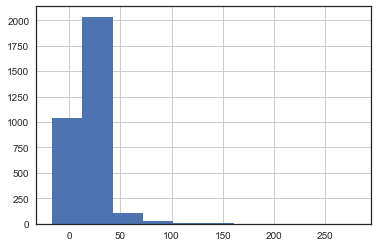

In [205]:
y_P6.hist()

In [206]:
X_P7, y_P7 = X, Y_data.raisingPrice

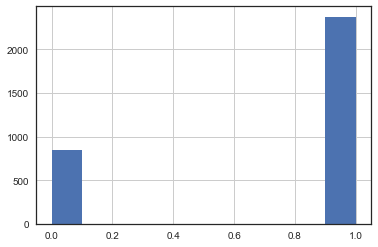

In [207]:
y_P7.hist()

In [208]:
X_P8, y_P8 = X, Y_data.raisingPrice

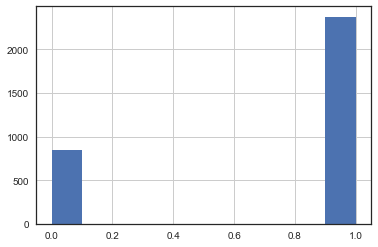

In [209]:
y_P8.hist()

In [210]:
X_P9, y_P9 = X, (Y_data['return'] < -0.10).astype('int')

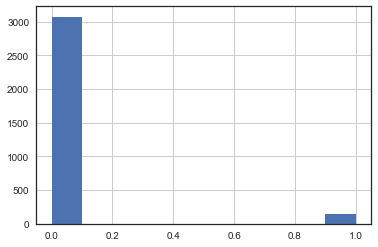

In [211]:
y_P9.hist()

In [212]:
features_pred = [X_P1, X_P2, X_P3, X_P4, X_P5, X_P6, X_P7, X_P8, X_P9]

In [213]:
targets_pred = [y_P1, y_P2, y_P3, y_P4, y_P5, y_P6, y_P7, y_P8, y_P9]

# Data to predict pre-processing 

In [ ]:
df_predict = df_predict.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

In [ ]:
processed_data_predict = copy.deepcopy(df_predict)

# Part 3: Feature reduction

Reduce features using PCA, select numeric fields for PCA

In [158]:
# Select features for PCA
data_pca = X.select_dtypes([np.number])
len(data_pca.columns)

60

In [159]:
data_pca.head(3)

,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,investmentReceived,...,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,0,0,0.492063,1,5.0,2000,14,30.50,68114956,64190.000000,...,0,0.646629,0.000104,0.000110,0.347292,0.005409,0.000117,0.000119,0.000119,0.000101
"Home BancShares Inc,Conway,AR",0,1,0.447917,0,8.0,2006,4,17.09,45000000,172172.815261,...,0,0.005285,0.000108,0.000112,0.000130,0.000121,0.000122,0.094196,0.000868,0.899056
Boise Cascade Co,0,1,0.447917,0,9.0,2013,8,27.21,247058826,615284.000000,...,0,0.000141,0.000101,0.000104,0.000132,0.005750,0.000739,0.942903,0.020339,0.029792


In [160]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(data_pca, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

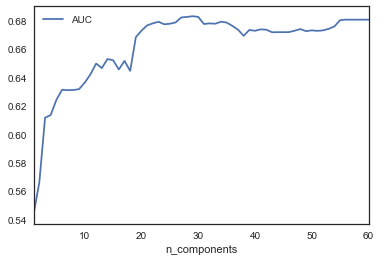

In [161]:
# Explore and print out results for the relationship between AUC and the number of PCA Component Features
estimators = []
estimators.append(('standardize', StandardScaler()))
pca = PCA()
estimators.append(('pca', pca))
estimators.append(('model', LogisticRegression()))
pipeline = Pipeline(estimators)

results = []
for c in range(1,61):
    pipeline.set_params(pca__n_components=c)
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )

df_auc_vs_pca = pd.DataFrame(results, columns=['AUC', 'n_components'])

df_auc_vs_pca.plot('n_components', 'AUC')
plt.savefig('pca_n_components.png')

In [162]:
cum_explained = np.cumsum(pca.explained_variance_ratio_)
cum_explained

array([0.11925781, 0.22631319, 0.29133791, 0.33060754, 0.36886387,
       0.40086442, 0.43146464, 0.46049948, 0.48575926, 0.50887419,
       0.53135985, 0.55291757, 0.57310127, 0.59283412, 0.61225145,
       0.63108058, 0.6495675 , 0.66727145, 0.68467478, 0.70145216,
       0.71802075, 0.73412206, 0.74975248, 0.76508264, 0.77937988,
       0.79338465, 0.80711865, 0.820538  , 0.8337174 , 0.8465347 ,
       0.8590084 , 0.87056946, 0.88170671, 0.89231635, 0.90258872,
       0.91258061, 0.92188755, 0.93045303, 0.93814844, 0.94510465,
       0.95180057, 0.95825579, 0.96420483, 0.96986943, 0.975149  ,
       0.98002701, 0.98461277, 0.98811594, 0.99148522, 0.994778  ,
       0.99653501, 0.99815139, 0.99906691, 0.99964574, 0.99985738,
       0.99995325, 1.        , 1.        , 1.        , 1.        ])

In [163]:
param_grid = {
    'pca__n_components': range(1, 45),
    'model__C': range(1, 10),
}
search = GridSearchCV(pipeline, param_grid, iid=False, cv=5)
search.fit(X_train_train, y_train_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.750):
{'model__C': 3, 'pca__n_components': 19}


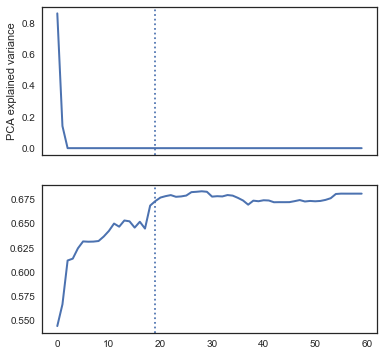

In [164]:
# Plot the PCA spectrum
pca.fit(X_train_train)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

ax1.plot(df_auc_vs_pca.AUC, linewidth=2)
ax1.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.savefig('pca_explained_variance.png')

**Commets**: We select no_components for PCA as 13 based on the above charactersitic.

# Part 4: Training, tuning, and testing of each model

**Steps**:

    Select appropriate features for each model

    pipelining and hyper-parameter tunining (as appropriate)

    baseline model comparisons

    advanced model comparisons between different model typre

    ensembles

    descriptions and explanations of which model is best for each predicition problem

    discussion of additional tasks or improvements that might boost performance

## 0. Random guessing model

### Process for prediction
1. Create pipeline
2. Select parameters grid
3. Create cross validation scheme
4. Search for the best estimator using Grid search
5. Find the best estimator

In [215]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', DummyClassifier(strategy='constant', constant=np.random.choice([0, 1]), random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============...Fitting the Random model...===============
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV] ................................................. , total=   0.1s
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s

Best parameter (CV score - roc_auc=0.500):
{}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.5,0.5,0.5,0.5,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.0



===============Confusion matrix...===============



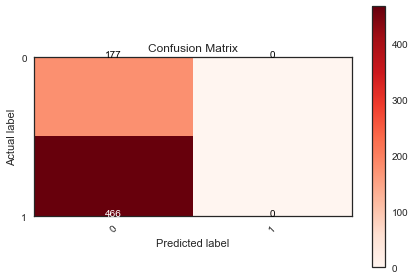

Accuracy =  0.2753

===============ROC curve on the Test data ...===============



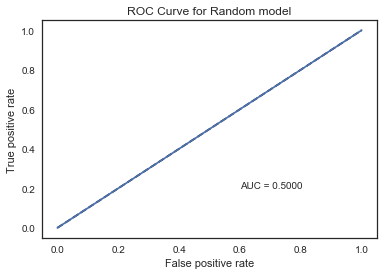

In [216]:
random_model_final = custom_train_test_function(random_model, X_P1, y_P1, name="Random model")

### Select data

In [217]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [218]:
y_hat_random = [np.random.choice([0, 1]) for v in y_test]
pd.Series(y_hat_random).value_counts()

1    325
0    318
dtype: int64

### Test the model (AUC, ROC....etc)

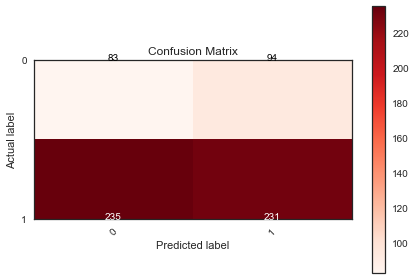

In [219]:
cm_random = confusion_matrix(y_test, y_hat_random)  
plot_confusion_matrix(cm_random)

In [220]:
# Calculate accuracy
accuracy_random = 1 - ((cm_random[0][1] + cm_random[1][0])/(cm_random[0][1] + cm_random[1][0] + cm_random[1][1] + cm_random[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_random))

Accuracy   = 0.4883


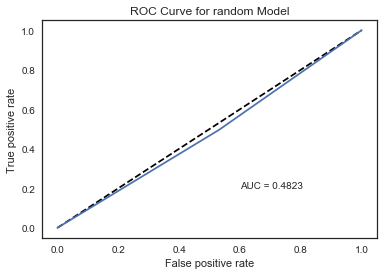

In [221]:
#plot roc curve
fpr_logit_random, tpr_logit_random, _ = roc_curve(y_test, y_hat_random)
best_auc_random = roc_auc_score(y_test, y_hat_random)
plot_roc(fpr_logit_random, tpr_logit_random, 'ROC Curve for random Model', 'AUC = %2.4f' % best_auc_random)

## A. Baseline model

In [222]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', DummyClassifier(strategy='most_frequent', random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
baseline_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

===============...Fitting the Baseline model...===============
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV] ................................................. , total=   0.0s

Best parameter (CV score - roc_auc=0.500):
{}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.5,0.5,0.5,0.5,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.0



===============Confusion matrix...===============



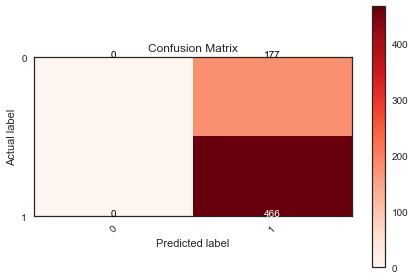

Accuracy =  0.7247

===============ROC curve on the Test data ...===============



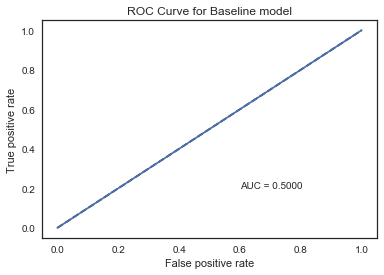

In [223]:
baseline_model_final = custom_train_test_function(baseline_model, X_P1, y_P1, name="Baseline model")

### Select data

In [224]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [225]:
#Look at the most commonly predicted outcome
most_frequent_outcome = Y_data['raisingPrice'].value_counts().idxmax()
print('Most frequent outcome =', most_frequent_outcome)

Most frequent outcome = 1


### Train the model

In [226]:
y_hat_baseline = [most_frequent_outcome ]*len(y_test)
pd.Series(y_hat_baseline).value_counts()

1    643
dtype: int64

### Test the model (AUC, ROC....etc)

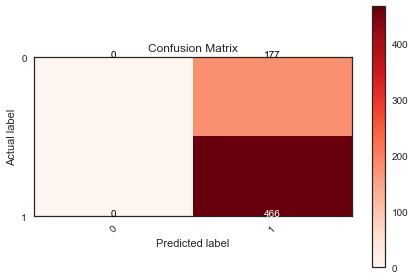

In [227]:
cm_baseline = confusion_matrix(y_test, y_hat_baseline)  
plot_confusion_matrix(cm_baseline)

In [228]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7247


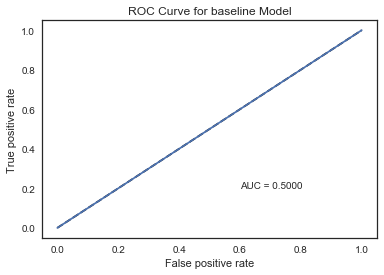

In [229]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_baseline)
best_auc_baseline = roc_auc_score(y_test, y_hat_baseline)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

## B. Linear model

In [230]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', LinearRegression(normalize=True, n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
linear_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

In [231]:
linear_model_final = custom_train_test_function(linear_model, X_P1, y_P1, name="Linear model", test_req=False)

===============...Fitting the Linear model...===============
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


KeyboardInterrupt: 

### B1 : Linear model without 'risk factor'

In [232]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [233]:
ols_model_p1 = LinearRegression(normalize=True, n_jobs=-1)

In [234]:
y_test.head(3)

issuer
Quintus Corp                    1
Alder BioPharmaceuticals Inc    1
VA Linux Systems Inc            1
Name: raisingPrice, dtype: int64

### Train the model

In [235]:
ols_model_p1.fit(X_train, y_train)
y_hat_ols_prob = ols_model_p1.predict(X_train_val)

### Validation and hyper parameter tuning

In [236]:
results = []
for i in range(1, 100):
    threshold = 0.01 * i
    y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
    correct  = [int(r[0]==r[1]) for r in zip(y_train_val, y_hats)]
    accuracy = sum(correct)/len(correct)
    results.append( (accuracy, threshold) )
optimal_p = sorted(results, reverse=True)[0][1]
print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])

Optimal probability threshold based on accuracy = 0.5900 and the corresponding accuracy is  0.7698289269051322


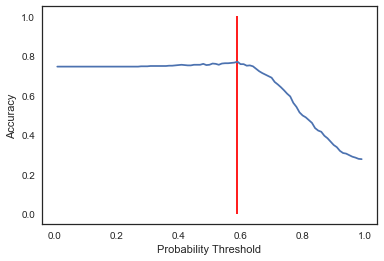

In [237]:
y,x = zip(*results)
plt.plot(x, y)
plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
plt.ylabel('Accuracy')
plt.xlabel('Probability Threshold')
plt.show()

### Test the model (AUC, ROC....etc)

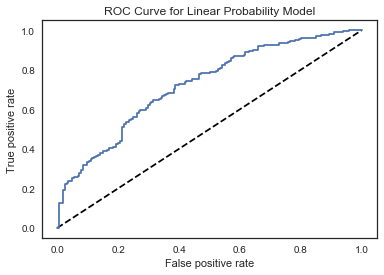

In [238]:
fpr_ols, tpr_ols, _ = roc_curve(y_train_val, y_hat_ols_prob)
auc_ols = roc_auc_score(y_train_val, y_hat_ols_prob)
plot_roc(fpr_ols, tpr_ols, 'ROC Curve for Linear Probability Model')

In [239]:
y_hat_ols_prob_test = ols_model_p1.predict(X_test)
y_hats   = [int(v >= optimal_p) for v in y_hat_ols_prob_test]

In [240]:
auc_ols = roc_auc_score(y_test, y_hats)
print('AUC for linear probability model = %2.4f' % auc_ols)

AUC for linear probability model = 0.5509


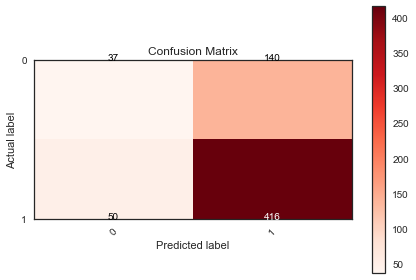

In [241]:
cm_baseline = confusion_matrix(y_test, y_hats)  
plot_confusion_matrix(cm_baseline)

In [242]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7045


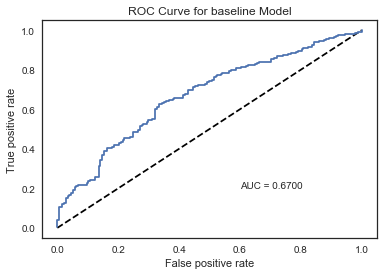

In [243]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_ols_prob_test)
best_auc_baseline = roc_auc_score(y_test, y_hat_ols_prob_test)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

In [244]:
linear_model_p1_final = {'model':ols_model_p1, 'threshold':optimal_p}
linear_model_p1_final

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.59}

### B2: Linear model for precition P2

In [272]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P2, y_P2, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [273]:
ols_model_p2 = LinearRegression(normalize=True, n_jobs=-1)

In [274]:
y_test.head(3)

issuer
Quintus Corp                    1
Alder BioPharmaceuticals Inc    1
VA Linux Systems Inc            1
Name: raisingPrice, dtype: int64

### Train the model

In [275]:
ols_model_p2.fit(X_train, y_train)
y_hat_ols_prob = ols_model_p2.predict(X_train_val)

### Validation and hyper parameter tuning

In [276]:
results = []
for i in range(1, 100):
    threshold = 0.01 * i
    y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
    correct  = [int(r[0]==r[1]) for r in zip(y_train_val, y_hats)]
    accuracy = sum(correct)/len(correct)
    results.append( (accuracy, threshold) )
optimal_p = sorted(results, reverse=True)[0][1]
print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])

Optimal probability threshold based on accuracy = 0.5800 and the corresponding accuracy is  0.7433903576982893


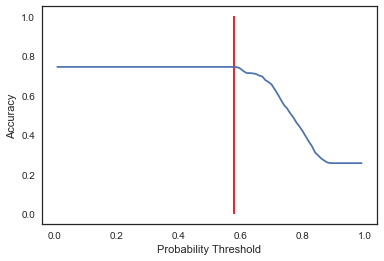

In [277]:
y,x = zip(*results)
plt.plot(x, y)
plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
plt.ylabel('Accuracy')
plt.xlabel('Probability Threshold')
plt.show()

### Test the model (AUC, ROC....etc)

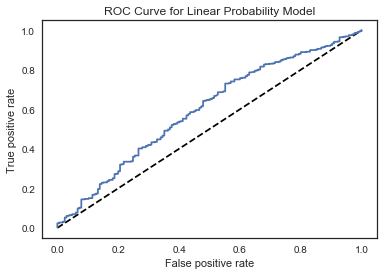

In [278]:
fpr_ols, tpr_ols, _ = roc_curve(y_train_val, y_hat_ols_prob)
auc_ols = roc_auc_score(y_train_val, y_hat_ols_prob)
plot_roc(fpr_ols, tpr_ols, 'ROC Curve for Linear Probability Model')

In [279]:
y_hat_ols_prob_test = ols_model_p2.predict(X_test)
y_hats   = [int(v >= optimal_p) for v in y_hat_ols_prob_test]

In [280]:
auc_ols = roc_auc_score(y_test, y_hats)
print('AUC for linear probability model = %2.4f' % auc_ols)

AUC for linear probability model = 0.5000


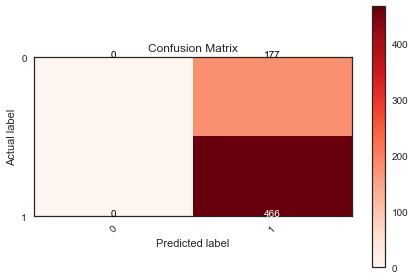

In [281]:
cm_baseline = confusion_matrix(y_test, y_hats)  
plot_confusion_matrix(cm_baseline)

In [282]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7247


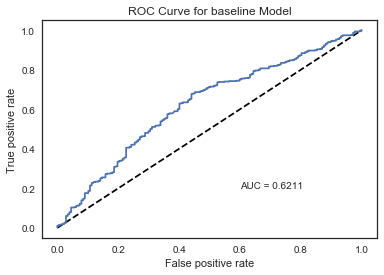

In [283]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_ols_prob_test)
best_auc_baseline = roc_auc_score(y_test, y_hat_ols_prob_test)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

In [284]:
linear_model_final_p2 = {'model':ols_model_p2, 'threshold':optimal_p}
linear_model_final_p2

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.58}

### B3: Linear model for precition P3

In [285]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P3, y_P3, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [286]:
ols_model_p3 = LinearRegression(normalize=True, n_jobs=-1)

In [287]:
y_test.head(3)

issuer
Quintus Corp                    1
Alder BioPharmaceuticals Inc    1
VA Linux Systems Inc            1
Name: raisingPrice, dtype: int64

### Train the model

In [288]:
ols_model_p3.fit(X_train, y_train)
y_hat_ols_prob = ols_model_p3.predict(X_train_val)

### Validation and hyper parameter tuning

In [289]:
results = []
for i in range(1, 100):
    threshold = 0.01 * i
    y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
    correct  = [int(r[0]==r[1]) for r in zip(y_train_val, y_hats)]
    accuracy = sum(correct)/len(correct)
    results.append( (accuracy, threshold) )
optimal_p = sorted(results, reverse=True)[0][1]
print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])

Optimal probability threshold based on accuracy = 0.5700 and the corresponding accuracy is  0.7651632970451011


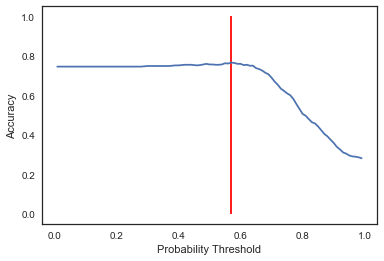

In [290]:
y,x = zip(*results)
plt.plot(x, y)
plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
plt.ylabel('Accuracy')
plt.xlabel('Probability Threshold')
plt.show()

### Test the model (AUC, ROC....etc)

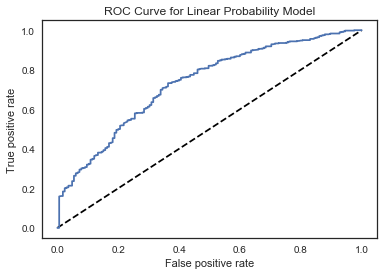

In [291]:
fpr_ols, tpr_ols, _ = roc_curve(y_train_val, y_hat_ols_prob)
auc_ols = roc_auc_score(y_train_val, y_hat_ols_prob)
plot_roc(fpr_ols, tpr_ols, 'ROC Curve for Linear Probability Model')

In [292]:
y_hat_ols_prob_test = ols_model_p3.predict(X_test)
y_hats   = [int(v >= optimal_p) for v in y_hat_ols_prob_test]

In [293]:
auc_ols = roc_auc_score(y_test, y_hats)
print('AUC for linear probability model = %2.4f' % auc_ols)

AUC for linear probability model = 0.5552


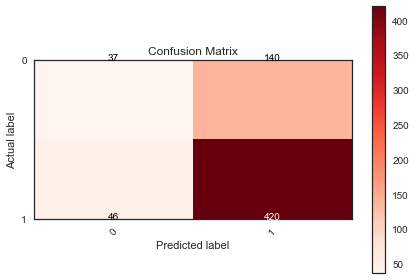

In [294]:
cm_baseline = confusion_matrix(y_test, y_hats)  
plot_confusion_matrix(cm_baseline)

In [295]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7107


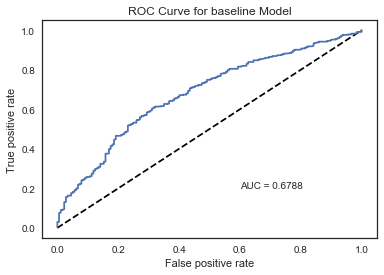

In [296]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_ols_prob_test)
best_auc_baseline = roc_auc_score(y_test, y_hat_ols_prob_test)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

In [297]:
linear_model_final_p3 = {'model':ols_model_p3, 'threshold':optimal_p}
linear_model_final_p3

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.5700000000000001}

### Comments on performance and relevance for prediction of P1 to P9

The AUC is above the baseline one, as we could have expected. The accuracy is also better than the baseline one. So this model is probably to simple to get very good results but is not so bad.

## C. Logit model

In [298]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', LogisticRegression(penalty='l1', n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-4, 5, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logit_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

===============...Fitting the Logit model...===============
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] model__C=0.0001 .................................................
[CV] model__C=0.0001 .................................................
[CV] model__C=0.0001 .................................................
[CV] .................................. model__C=0.0001, total=   0.1s
[CV] model__C=0.0001 .................................................
[CV] model__C=0.001 ..................................................
[CV] .................................. model__C=0.0001, total=   0.2s
[CV] model__C=0.001 ..................................................
[CV] .................................. model__C=0.0001, total=   0.1s
[CV] ................................... model__C=0.001, total=   0.1s
[CV] .................................. model__C=0.0001, total=   0.1s
[CV] model__C=0.001 ..................................................
[CV] model__C=0.001 .......

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s


[CV] ................................. model__C=10000.0, total=   2.4s
[CV] model__C=100000.0 ...............................................
[CV] .................................. model__C=1000.0, total=   3.2s
[CV] model__C=100000.0 ...............................................
[CV] ................................ model__C=100000.0, total=   1.2s
[CV] model__C=100000.0 ...............................................
[CV] ................................ model__C=100000.0, total=   1.5s
[CV] ................................ model__C=100000.0, total=   2.9s
[CV] ................................. model__C=10000.0, total=   3.5s
[CV] ................................ model__C=100000.0, total=   2.1s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.2s finished



Best parameter (CV score - roc_auc=0.683):
{'model__C': 0.1}

===============Training results with cross validation...===============



,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,9,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,9,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
2,0.649268,0.668826,0.584830,0.656791,0.639929,0.032567,8,0.670361,0.661696,0.660480,0.659165,0.662926,0.004385
3,0.669089,0.726996,0.652951,0.682621,0.682915,0.027533,1,0.723179,0.705849,0.721252,0.715897,0.716545,0.006727
4,0.661695,0.719280,0.648948,0.672421,0.675586,0.026560,2,0.726177,0.712244,0.729686,0.726277,0.723596,0.006705
5,0.660440,0.716059,0.642191,0.668827,0.671879,0.027264,3,0.725993,0.712381,0.730311,0.727036,0.723931,0.006856
6,0.659838,0.715668,0.641712,0.667763,0.671245,0.027331,4,0.725828,0.712533,0.730218,0.726914,0.723873,0.006744
7,0.659800,0.715579,0.641762,0.667700,0.671210,0.027287,5,0.725833,0.712555,0.730239,0.726860,0.723872,0.006734
8,0.659800,0.715567,0.641749,0.667713,0.671207,0.027285,6,0.725818,0.712545,0.730228,0.726844,0.723859,0.006733
9,0.659750,0.715579,0.641749,0.667713,0.671198,0.027295,7,0.725819,0.712545,0.730234,0.726842,0.723860,0.006734


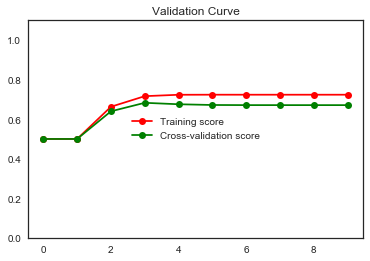


===============ROC curve on the Test data ...===============



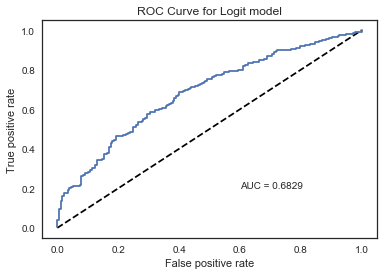

In [299]:
logit_model_final = custom_train_test_function(logit_model, X_P1, y_P1, name="Logit model", proba=True, plot_train_score=True)


In [ ]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('logit_model_l1', LogisticRegression()))  # tell it to use a logit model
pipeline = Pipeline(estimators) 
pipeline.set_params(logit_model_l1__penalty='l1') 

### Train the model

### Validation and hyper parameter tuning

In [ ]:
# Tune C  
results = []
for c in np.logspace(-4, 5, 10):
    pipeline.set_params(logit_model_l1__C=c) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )
logit_model_l1 = pipeline.named_steps['logit_model_l1']      # capture model so we can use it later

In [ ]:
# View results 
print('C'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, c) in results:
    print('{0:.4f}'.format(c).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

In [ ]:
best_C=1.0

In [ ]:
pipeline.set_params(logit_model_l1__C=best_C)
pipeline.fit(X_train,y_train)
y_prob_logit_lasso = pipeline.predict_proba(X_train_val)
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_train_val, y_prob_logit_lasso[:, 1])
best_auc_logit_lasso = roc_auc_score(y_train_val, y_prob_logit_lasso[:,1])
plot_roc(fpr_logit_lasso, tpr_logit_lasso, 'ROC Curve for L1 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_lasso)

In [ ]:
 #Test final model 
pipeline.set_params(logit_model_l1__C=best_C)
pipeline.fit(X_train,y_train)
y_prob_logit_lasso = pipeline.predict_proba(X_test)
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_test, y_prob_logit_lasso[:, 1])
best_auc_logit_lasso = roc_auc_score(y_test, y_prob_logit_lasso[:, 1])
plot_roc(fpr_logit_lasso, tpr_logit_lasso, 'ROC Curve for L1 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_lasso)

In [ ]:
estimators2 = []
estimators2.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators2.append(('ridge', Ridge()))  # tell it to use a logit model
pipeline2 = Pipeline(estimators2) 
#pipeline2.set_params(logit_model_l2__penalty='l2') 

In [ ]:
pipeline.get_params()

In [ ]:
# Tune C  
results2 = []
for c in np.logspace(-4, 5, 10):
    pipeline2.set_params(ridge__alpha=c) 
    pipeline2.fit(X_train_train,y_train_train)
    y_train_pred2 = pipeline2.predict(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml2 = roc_auc_score(y_train_val, y_train_pred2)   
    results2.append( (auc_lml2, c)  )
ridge = pipeline2.named_steps['ridge']      # capture model so we can use it later

In [ ]:
# View results 
print('C'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, c) in results2:
    print('{0:.4f}'.format(c).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

In [ ]:
best_c=0.100

In [ ]:
 #Test final model 
pipeline2.set_params(ridge__alpha=best_c)
pipeline2.fit(X_train,y_train)
y_prob_logit_ridge = pipeline2.predict(X_test)
fpr_logit_ridge, tpr_logit_ridge, _ = roc_curve(y_test, y_prob_logit_ridge)
best_auc_logit_ridge = roc_auc_score(y_test, y_prob_logit_ridge)
plot_roc(fpr_logit_ridge, tpr_logit_ridge, 'ROC Curve for L2 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_ridge)

### Comparison of logistic models

In [ ]:
logit_model = Pipeline([('s', StandardScaler()), ('m', LogisticRegression(penalty='l2', C = 1e10))]).fit(X_train_train, y_train_train).named_steps['m']
print('REGULARIZATION'.center(20), 'NONE'.center(10), 'L1'.center(10))
print('=' * 50)
features = list(set(list(processed_data.columns)) - set(['raisingPrice','rf','closeDay1','offerPrice']))
for (varname, lm_coef, lml1_coef) in zip(features, logit_model.coef_[0], logit_model_l1.coef_[0]):
    lm_coeff  = "{0:.4f}".format(lm_coef).rjust(10)
    lml1_coef = "{0:.4f}".format(lml1_coef).rjust(10) if lml1_coef > 0.0001 else ""
    
    print(str(varname).center(20), lm_coeff, lml1_coef)

In [ ]:
#
"""def train_logit_model(X, y, param, param_range):
    # Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
    X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
    
    estimators = []
    estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
    estimators.append(('logit_model_l1', LogisticRegression()))  # tell it to use a logit model
    pipeline = Pipeline(estimators) 
    pipeline.set_params(logit_model_l1__penalty='l1') 
    
    # Define model
    cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=SEED)

    # Now use the validation_curve() function to train/validate models...
    train_scores, test_scores = validation_curve(pipeline, X_train, y_train, param, param_range, cv=cv, n_jobs=-1)
    
    return pipeline, train_scores, test_scores
    """

In [ ]:
#param, param_range = 'logit_model_l1__C', np.logspace(-5, 5, 11)
#logit_P1, train_score_P1, test_score_P1 = train_logit_model(X_P1, y_P1, param, param_range)
#plot_validation_curve(train_score_P1, test_score_P1, param_range, x_logscale=True)

In [ ]:
logit_model_final = copy.deepcopy(pipeline)
logit_model_final

### Comments on performance and relevance for prediction of P1 to P9

We get a very high auc for the lasso model: it may be good to use it at least for P1

## D. KNN

1. We use KNN for classification purposes. In this section, we build the pipeline to classify positive and negetive cases in the given data set

In [300]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', KNeighborsClassifier(n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__n_neighbors' : range(1, 50, 5),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
knn_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============...Fitting the KNN model...===============
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] model__n_neighbors=1 ............................................
[CV] model__n_neighbors=1 ............................................
[CV] model__n_neighbors=1 ............................................
[CV] model__n_neighbors=1 ............................................
[CV] ............................. model__n_neighbors=1, total=   0.3s
[CV] ............................. model__n_neighbors=1, total=   0.4s
[CV] ............................. model__n_neighbors=1, total=   0.4s
[CV] model__n_neighbors=6 ............................................
[CV] model__n_neighbors=6 ............................................
[CV] model__n_neighbors=6 ............................................
[CV] ............................. model__n_neighbors=1, total=   0.4s
[CV] model__n_neighbors=6 ............................................
[CV] ........................

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s


[CV] ............................ model__n_neighbors=41, total=   0.3s
[CV] model__n_neighbors=46 ...........................................
[CV] ............................ model__n_neighbors=41, total=   0.4s
[CV] model__n_neighbors=46 ...........................................
[CV] ............................ model__n_neighbors=46, total=   0.2s
[CV] ............................ model__n_neighbors=46, total=   0.4s
[CV] ............................ model__n_neighbors=46, total=   0.3s
[CV] ............................ model__n_neighbors=46, total=   0.3s

Best parameter (CV score - roc_auc=0.640):
{'model__n_neighbors': 41}

===============Training results with cross validation...===============



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.8s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.526758,0.568576,0.524166,0.548155,0.541914,0.017990,10,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.593204,0.635574,0.618303,0.593519,0.610150,0.017865,9,0.815538,0.809078,0.814348,0.806017,0.811245,0.003876
2,0.595187,0.628520,0.616624,0.613123,0.613363,0.011946,8,0.756298,0.751689,0.752087,0.746576,0.751662,0.003448
3,0.607276,0.623582,0.622490,0.631220,0.621142,0.008683,7,0.732317,0.720943,0.726475,0.728198,0.726983,0.004083
4,0.609642,0.629638,0.645507,0.633359,0.629537,0.012898,5,0.721078,0.713393,0.714228,0.717291,0.716498,0.003017
5,0.608117,0.636092,0.637405,0.635770,0.629346,0.012272,6,0.717970,0.712170,0.715090,0.709382,0.713653,0.003207
6,0.615354,0.633844,0.628160,0.646236,0.630899,0.011102,4,0.705546,0.699575,0.696602,0.697568,0.699823,0.003474
7,0.620671,0.642766,0.626771,0.650077,0.635071,0.011839,3,0.701154,0.695160,0.694494,0.687800,0.694652,0.004730
8,0.624261,0.643833,0.638643,0.651836,0.639643,0.010048,1,0.701296,0.693336,0.691750,0.684930,0.692828,0.005821
9,0.618260,0.645999,0.635959,0.645705,0.636481,0.011269,2,0.693930,0.689632,0.695272,0.683206,0.690510,0.004703


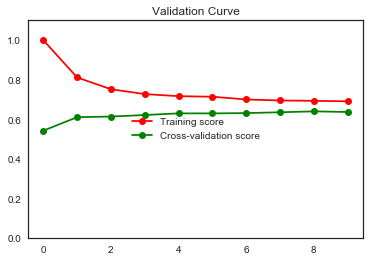


===============ROC curve on the Test data ...===============



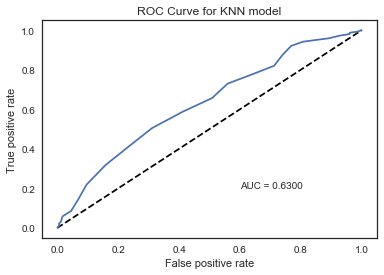

In [301]:
knn_model_final = custom_train_test_function(knn_model, X_P1, y_P1, name="KNN model", proba=True, plot_train_score=True)


## E. Decision trees

In [302]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', DecisionTreeClassifier(random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__max_depth' : range(1, 32, 2),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
decision_trees_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============...Fitting the Decision tree model...===============
Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] model__max_depth=1 ..............................................
[CV] model__max_depth=1 ..............................................
[CV] model__max_depth=1 ..............................................
[CV] ............................... model__max_depth=1, total=   0.1s
[CV] ............................... model__max_depth=1, total=   0.0s
[CV] model__max_depth=1 ..............................................
[CV] model__max_depth=3 ..............................................
[CV] model__max_depth=3 ..............................................
[CV] ............................... model__max_depth=1, total=   0.1s
[CV] model__max_depth=3 ..............................................
[CV] ............................... model__max_depth=3, total=   0.1s
[CV] ............................... model__max_depth=3, total=   0.1s
[CV] ..............

[CV] model__max_depth=31 .............................................
[CV] model__max_depth=31 .............................................
[CV] .............................. model__max_depth=29, total=   0.2s
[CV] model__max_depth=29 .............................................
[CV] .............................. model__max_depth=29, total=   0.2s
[CV] model__max_depth=29 .............................................
[CV] .............................. model__max_depth=31, total=   0.2s
[CV] model__max_depth=31 .............................................
[CV] .............................. model__max_depth=31, total=   0.2s
[CV] model__max_depth=31 .............................................
[CV] .............................. model__max_depth=29, total=   0.2s
[CV] .............................. model__max_depth=29, total=   0.1s
[CV] .............................. model__max_depth=31, total=   0.1s
[CV] .............................. model__max_depth=31, total=   0.1s

Best 

[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    3.1s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.575660,0.590343,0.526067,0.584768,0.569209,0.025454,4,0.599753,0.594841,0.600972,0.596694,0.598065,0.002427
1,0.622026,0.649636,0.609817,0.649425,0.632726,0.017350,1,0.700428,0.686485,0.699771,0.698040,0.696181,0.005665
2,0.614927,0.658199,0.610688,0.631195,0.628752,0.018645,2,0.772224,0.742721,0.778170,0.779390,0.768126,0.014916
3,0.610571,0.631722,0.597074,0.643673,0.620760,0.018097,3,0.866035,0.832297,0.875597,0.870461,0.861097,0.016969
4,0.562642,0.542920,0.572618,0.581945,0.565031,0.014476,5,0.923636,0.920655,0.935817,0.942272,0.930595,0.008816
5,0.555857,0.527045,0.499558,0.575029,0.539372,0.028637,16,0.954528,0.973691,0.970715,0.977305,0.969060,0.008708
6,0.590253,0.522505,0.526666,0.536936,0.544090,0.027165,13,0.982348,0.992306,0.987187,0.994296,0.989034,0.004651
7,0.599669,0.522865,0.536208,0.537935,0.549169,0.029733,8,0.992475,0.998102,0.992603,0.999307,0.995622,0.003113
8,0.585954,0.525321,0.518401,0.528026,0.539425,0.027092,15,0.998585,0.999737,0.996273,0.999994,0.998647,0.001470
9,0.584799,0.538885,0.524488,0.546687,0.548715,0.022303,9,0.999658,0.999996,0.998292,1.000000,0.999487,0.000704


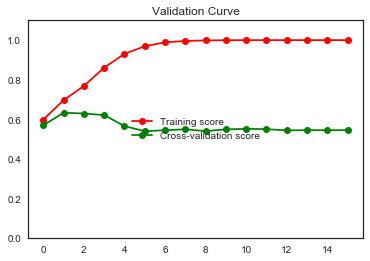


===============ROC curve on the Test data ...===============



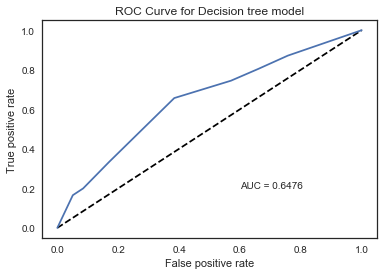

In [303]:
decision_trees_model_final = custom_train_test_function(decision_trees_model, X_P1, y_P1, name="Decision tree model", proba=True, plot_train_score=True)


In [ ]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [ ]:
# Build pipeline
estimators = []
estimators.append(('DTC_model', DecisionTreeClassifier()))
pipeline = Pipeline(estimators) 


### Train the model

In [ ]:
'''# Fit a one-tree Model      
dtc = DecisionTreeClassifier().fit(X_train_train,y_train_train)
y_train_predDT = dtc.predict_proba(X_train_val)
auc_DT = roc_auc_score(y_train_val, y_train_predDT[:,1])
auc_DT'''

### Validation and hyper parameter tuning

In [ ]:
# Tune D   
results = []
for D in range(1,32):
    pipeline.set_params(DTC_model__max_depth=D) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_dtc = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append((auc_dtc, D))

In [ ]:
# View results 
df = pd.DataFrame(results)
plt.figure(1)
plt.plot(df[1],df[0])
plt.xlabel('max depth')
plt.ylabel('AUC')
plt.show()

In [ ]:
# Select best D
r = np.array(results)
best_D = r[np.argmax(r[:,0]),1]
print ('"best_D" = ', best_D)

### Test the model (AUC, ROC....etc)

In [ ]:
# Test model
y_test_pred_DT = pipeline.predict_proba(X_test) 
dtc = DecisionTreeClassifier().fit(X_train,y_train)
y_train_predDT = dtc.predict_proba(X_test)
auc_DT = roc_auc_score(y_test, y_train_predDT[:,1])
auc_DT

In [ ]:
# Plot the ROC
fpr, tpr , _ = roc_curve(y_test, y_train_predDT[:,1])
auc = roc_auc_score(y_test, y_train_predDT[:,1])
plot_roc(fpr, tpr)
print(auc)



In [ ]:
# Test final model
#pipeline.set_params(DTC_model__max_depth==int(best_D))
#DTC = pipeline.fit(X_train,y_train)
#y_test_pred_DTC = pipeline.predict_proba(X_test) 

In [ ]:
# Plot the ROC

#fpr, tpr , _ = roc_curve(y_test, y_test_pred_DTC[:,1])
#auc = roc_auc_score(y_test, y_test_pred_DTC[:,1])
#plot_roc(fpr, tpr)
#print(auc)

### Comments on performance and relevance for prediction of P1 to P9

In [570]:
decision_trees_model_final = copy.deepcopy(pipeline)
decision_trees_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## F. Random forests

In [304]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', RandomForestClassifier(n_jobs=-1)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__n_estimators' : range(1, 251, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
random_forests_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============...Fitting the Random forests model...===============
Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] model__n_estimators=1 ...........................................
[CV] model__n_estimators=1 ...........................................
[CV] model__n_estimators=1 ...........................................
[CV] model__n_estimators=1 ...........................................
[CV] ............................ model__n_estimators=1, total=   0.2s
[CV] ............................ model__n_estimators=1, total=   0.2s
[CV] model__n_estimators=11 ..........................................
[CV] ............................ model__n_estimators=1, total=   0.2s
[CV] model__n_estimators=11 ..........................................
[CV] ............................ model__n_estimators=1, total=   0.2s
[CV] model__n_estimators=11 ..........................................
[CV] model__n_estimators=11 ..........................................
[CV] ............

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


[CV] ........................... model__n_estimators=81, total=   1.4s
[CV] model__n_estimators=91 ..........................................
[CV] ........................... model__n_estimators=81, total=   1.4s
[CV] model__n_estimators=91 ..........................................
[CV] ........................... model__n_estimators=91, total=   1.4s
[CV] model__n_estimators=101 .........................................
[CV] ........................... model__n_estimators=91, total=   1.5s
[CV] model__n_estimators=101 .........................................
[CV] ........................... model__n_estimators=91, total=   1.5s
[CV] ........................... model__n_estimators=91, total=   1.5s
[CV] model__n_estimators=101 .........................................
[CV] model__n_estimators=101 .........................................
[CV] .......................... model__n_estimators=101, total=   1.7s
[CV] model__n_estimators=111 .........................................
[CV] .

[CV] .......................... model__n_estimators=231, total=   3.6s
[CV] model__n_estimators=241 .........................................
[CV] .......................... model__n_estimators=231, total=   3.7s
[CV] model__n_estimators=241 .........................................
[CV] .......................... model__n_estimators=231, total=   3.9s
[CV] model__n_estimators=241 .........................................
[CV] .......................... model__n_estimators=231, total=   4.8s
[CV] model__n_estimators=241 .........................................
[CV] .......................... model__n_estimators=241, total=   4.8s
[CV] .......................... model__n_estimators=241, total=   4.6s
[CV] .......................... model__n_estimators=241, total=   4.7s
[CV] .......................... model__n_estimators=241, total=   3.6s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.7s finished



Best parameter (CV score - roc_auc=0.697):
{'model__n_estimators': 231}

===============Training results with cross validation...===============



,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.518372,0.567263,0.540009,0.513833,0.534869,0.021157,25,0.829958,0.841157,0.842556,0.833289,0.836740,5.273702e-03
1,0.640656,0.659102,0.662979,0.670719,0.658364,0.011046,24,0.999155,0.998742,0.998987,0.999752,0.999159,3.725444e-04
2,0.662675,0.673025,0.652547,0.669459,0.664427,0.007802,23,0.999996,0.999989,0.999979,0.999994,0.999989,6.484864e-06
3,0.644541,0.704150,0.661356,0.701997,0.678011,0.025769,21,1.000000,1.000000,0.999997,1.000000,0.999999,1.213652e-06
4,0.647830,0.677572,0.670316,0.709350,0.676267,0.022024,22,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,0.672379,0.700980,0.675924,0.694043,0.685831,0.012001,17,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
6,0.647171,0.708993,0.664236,0.701415,0.680454,0.025616,20,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
7,0.660271,0.696415,0.680906,0.693189,0.682695,0.014181,19,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
8,0.671468,0.704611,0.677938,0.689898,0.685979,0.012627,16,1.000000,1.000000,1.000000,1.000000,1.000000,5.551115e-17
9,0.664501,0.690624,0.680350,0.695644,0.682780,0.011906,18,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


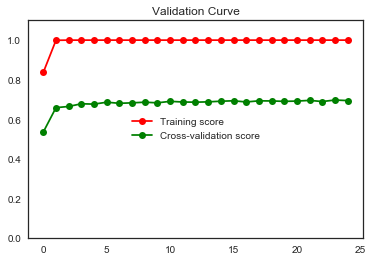


===============ROC curve on the Test data ...===============



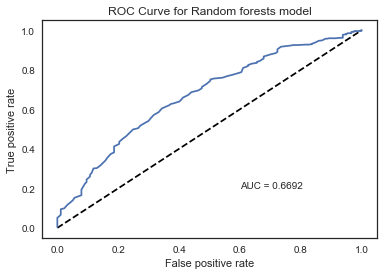

In [305]:
random_forests_model_final = custom_train_test_function(random_forests_model, X_P1, y_P1, name="Random forests model", proba=True, plot_train_score=True)


In [542]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
#X = data.loc[:, features]

In [543]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [544]:
# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('rfc_model', RandomForestClassifier()))
pipeline = Pipeline(estimators) 

### Train the model

### Validation and hyper parameter tuning

In [545]:
# Tune N   
results = []
for N in range(1,250,10):
    pipeline.set_params(rfc_model__n_estimators=N) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_rfc = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append((auc_rfc, N))

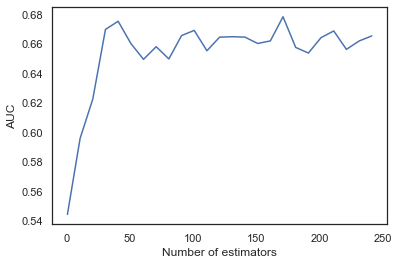

In [546]:
# View results 
df = pd.DataFrame(results)
plt.figure(1)
plt.plot(df[1],df[0])
plt.xlabel('Number of estimators')
plt.ylabel('AUC')
plt.show()

In [547]:
# Select best N
r = np.array(results)
best_N = r[np.argmax(r[:,0]),1]
print ('"best_N" = ', best_N)

"best_N" =  171.0


### Test the model (AUC, ROC....etc)

In [548]:
# Test final model
pipeline.set_params(rfc_model__n_estimators=int(best_N))
RFM = pipeline.fit(X_train,y_train)
y_test_pred_RF = pipeline.predict_proba(X_test) 




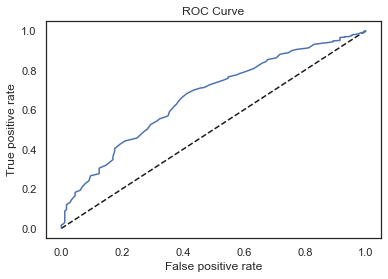

0.6654118474333793


In [549]:
# Plot the ROC

fpr, tpr , _ = roc_curve(y_test, y_test_pred_RF[:,1])
auc = roc_auc_score(y_test, y_test_pred_RF[:,1])
plot_roc(fpr, tpr)
print(auc)


In [571]:
random_forest_model_final = copy.deepcopy(pipeline)
random_forest_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## G. SVC

Using numeric data and SVC classifier for predicting positive and negatve cases

In [306]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', SVC(probability=True, random_state=SEED)))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-2, 3, 5),
    'model__kernel' : ('linear', 'rbf')
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
svc_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============...Fitting the SVC model...===============
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] model__C=0.01, model__kernel=linear .............................
[CV] model__C=0.01, model__kernel=linear .............................
[CV] model__C=0.01, model__kernel=linear .............................
[CV] model__C=0.01, model__kernel=linear .............................
[CV] .............. model__C=0.01, model__kernel=linear, total=   2.2s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] .............. model__C=0.01, model__kernel=linear, total=   2.4s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] .............. model__C=0.01, model__kernel=linear, total=   2.7s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] .............. model__C=0.01, model__kernel=linear, total=   2.7s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] ................. model_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 855.3min


[CV] ............... model__C=1000.0, model__kernel=rbf, total=   4.8s
[CV] model__C=1000.0, model__kernel=rbf ..............................
[CV] ............... model__C=1000.0, model__kernel=rbf, total=   5.5s
[CV] model__C=1000.0, model__kernel=rbf ..............................
[CV] ............... model__C=1000.0, model__kernel=rbf, total=   4.9s
[CV] model__C=1000.0, model__kernel=rbf ..............................
[CV] ............... model__C=1000.0, model__kernel=rbf, total=   5.0s
[CV] ........... model__C=1000.0, model__kernel=linear, total=659.8min
[CV] ........... model__C=1000.0, model__kernel=linear, total=706.7min
[CV] ........... model__C=1000.0, model__kernel=linear, total=789.9min


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 973.3min finished



Best parameter (CV score - roc_auc=0.654):
{'model__C': 0.1778279410038923, 'model__kernel': 'rbf'}

===============Training results with cross validation...===============



,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.642853,0.681316,0.615645,0.607472,0.636821,0.028836,8,0.691520,0.661627,0.698217,0.667251,0.679654,0.015526
1,0.626006,0.675981,0.635283,0.673231,0.652625,0.022245,3,0.884726,0.876812,0.869112,0.890990,0.880410,0.008233
2,0.646317,0.681051,0.613536,0.625405,0.641577,0.025635,7,0.692948,0.662833,0.696824,0.677297,0.682476,0.013493
3,0.627525,0.676031,0.638112,0.674332,0.654000,0.021518,1,0.887069,0.881934,0.870018,0.894076,0.883274,0.008783
4,0.644535,0.681354,0.613233,0.659537,0.649665,0.024775,4,0.693475,0.662235,0.697665,0.685840,0.684804,0.013702
5,0.615473,0.663655,0.637632,0.673269,0.647507,0.022628,6,0.923084,0.915141,0.914484,0.919130,0.917959,0.003452
6,0.644899,0.681304,0.618815,0.652222,0.649310,0.022257,5,0.694288,0.664368,0.698622,0.698752,0.689007,0.014339
7,0.582382,0.638965,0.618070,0.651691,0.622777,0.026229,9,0.990746,0.993961,0.990269,0.995083,0.992515,0.002053
8,0.640392,0.693163,0.632075,0.648438,0.653517,0.023609,2,0.697985,0.680190,0.707950,0.700288,0.696603,0.010169
9,0.583562,0.613997,0.591384,0.658031,0.611744,0.028967,10,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


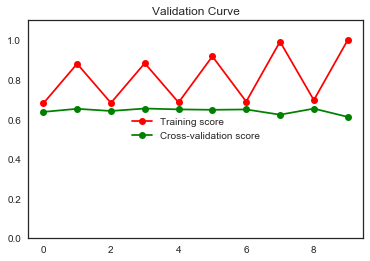


===============ROC curve on the Test data ...===============



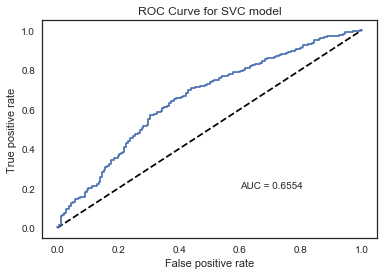

In [308]:
svc_model_final = custom_train_test_function(svc_model, X_P1, y_P1, name="SVC model", proba=True, plot_train_score=True)


In [572]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [551]:
# Build pipeline for features except 'rf'
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('svc', SVC(C=1, probability=True, random_state=SEED)))
pipeline = Pipeline(estimators) 

### Train the model

In [554]:
# Tune K
results = []
for c in np.logspace(-4, 5, 10):
    pipeline.set_params(svc__C=c) 
    pipeline.fit(X_train_train,y_train_train)
    y_hat = pipeline.predict_proba(X_train_val)
    auc = roc_auc_score(y_train_val, y_hat[:,1])
    results.append( (auc, c) )
    

    C       AUC    
0.0001      0.6104 
 10.0      0.6538 


In [556]:
# View results 
print('C'.rjust(5), '   ', 'AUC'.center(8), '\n', '=' * 20)
for (auc, k) in results:
    print('{0}'.format(k).rjust(5), '   ',  '{0:.4f}'.format(auc).center(8))

    C       AUC    
0.0001      0.6104 
0.001      0.6224 
 0.01      0.6466 
  0.1      0.6504 
  1.0      0.6539 
 10.0      0.6538 
100.0      0.6404 
1000.0      0.6313 
10000.0      0.6313 
100000.0      0.6313 


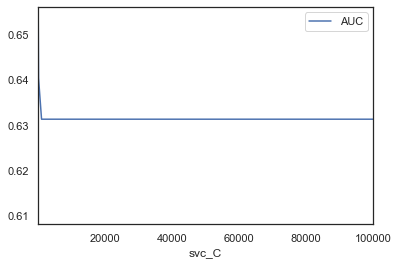

In [555]:
df_auc_svc = pd.DataFrame(results, columns=['AUC', 'svc_C'])

df_auc_svc.plot('svc_C', 'AUC')
plt.savefig('svc_C_numeric.png')

### Validation and hyper parameter tuning

In [ ]:
param_grid = {
    'svc__C': np.arange(1, 6, 1),
}
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [557]:
pipeline.set_params(svc__C=1)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.05)


### Validate the final parameters

In [558]:
# Validation score
y_hat = pipeline.predict_proba(X_train_val)
auc = roc_auc_score(y_train_val, y_hat[:,1])
print(f"AUC : {auc:.3f}")

AUC : 0.631


### Test the model

In [309]:
# Performance on test set
pipeline.fit(X_test,y_test)
y_hat = pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, y_hat[:,1])
print(f"AUC : {auc:.3f}")

AUC : 0.940


In [573]:
svc_model_final = copy.deepcopy(pipeline)
svc_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## H. Support Vector Regression

In [310]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', SVR()))  # tell it to use a logit model
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__C' : np.logspace(-2, 3, 5),
    'model__kernel' : ('linear', 'rbf')
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
svr_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


===============...Fitting the SVR model...===============
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] model__C=0.01, model__kernel=linear .............................
[CV] model__C=0.01, model__kernel=linear .............................
[CV] model__C=0.01, model__kernel=linear .............................
[CV] model__C=0.01, model__kernel=linear .............................
[CV] .............. model__C=0.01, model__kernel=linear, total=   0.7s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] .............. model__C=0.01, model__kernel=linear, total=   1.2s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] .............. model__C=0.01, model__kernel=linear, total=   1.2s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] .............. model__C=0.01, model__kernel=linear, total=   1.2s
[CV] model__C=0.01, model__kernel=rbf ................................
[CV] ................. model_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 505.3min


[CV] ............... model__C=1000.0, model__kernel=rbf, total=   4.9s
[CV] model__C=1000.0, model__kernel=rbf ..............................
[CV] ............... model__C=1000.0, model__kernel=rbf, total=   4.9s
[CV] model__C=1000.0, model__kernel=rbf ..............................
[CV] ............... model__C=1000.0, model__kernel=rbf, total=   4.9s
[CV] model__C=1000.0, model__kernel=rbf ..............................
[CV] ............... model__C=1000.0, model__kernel=rbf, total=   4.9s
[CV] ........... model__C=1000.0, model__kernel=linear, total=223.6min
[CV] ........... model__C=1000.0, model__kernel=linear, total=204.8min
[CV] ........... model__C=1000.0, model__kernel=linear, total=537.2min


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 586.2min finished



Best parameter (CV score - roc_auc=0.658):
{'model__C': 1000.0, 'model__kernel': 'linear'}

===============Training results with cross validation...===============



,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.646305,0.679586,0.614344,0.648691,0.647232,0.023084,4,0.693018,0.662019,0.697176,0.682591,0.683701,0.013599
1,0.625341,0.674301,0.634652,0.671269,0.651391,0.021673,3,0.881480,0.884831,0.867695,0.890170,0.881044,0.008307
2,0.645388,0.681569,0.615342,0.622279,0.641145,0.025855,6,0.693359,0.661744,0.698301,0.679818,0.683306,0.014169
3,0.627851,0.676044,0.637809,0.674269,0.653993,0.021463,2,0.886869,0.882194,0.869993,0.893929,0.883246,0.008718
4,0.643644,0.677351,0.613321,0.627379,0.640424,0.023868,7,0.694005,0.662337,0.698537,0.681123,0.684001,0.014044
5,0.597848,0.654789,0.632568,0.662094,0.636825,0.024993,8,0.960616,0.948376,0.952909,0.954271,0.954043,0.004378
6,0.645288,0.682428,0.620722,0.636947,0.646346,0.022627,5,0.694642,0.667581,0.701193,0.693222,0.689159,0.012816
7,0.568699,0.609274,0.594163,0.609067,0.595300,0.016535,9,0.999784,0.998369,0.998346,0.996262,0.998190,0.001256
8,0.635195,0.699566,0.646132,0.650147,0.657760,0.024749,1,0.702056,0.684545,0.714457,0.700903,0.700490,0.010629
9,0.561355,0.576564,0.580056,0.624127,0.585526,0.023369,10,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


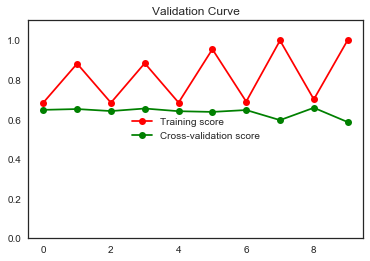

In [311]:
svr_model_final = custom_train_test_function(svr_model, X_P1, y_P1, name="SVR model", proba=True, plot_train_score=True, test_req=False)


In [314]:
svr_model_final.best_parameter_

AttributeError: 'Pipeline' object has no attribute 'best_parameter_'

## I. CNN, RNN

In [315]:
# Pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('model', MLPClassifier(solver='lbfgs', random_state=SEED)))
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'model__alpha' : np.logspace(-4, 5, 10),
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
mlp_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)


In [316]:
cnn_model_final = custom_train_test_function(mlp_model, X_P1, y_P1, name="CNN model", proba=True, plot_train_score=True, test_req=True)

===============...Fitting the CNN model...===============
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] model__alpha=0.0001 .............................................
[CV] model__alpha=0.0001 .............................................
[CV] model__alpha=0.0001 .............................................
[CV] model__alpha=0.0001 .............................................


KeyboardInterrupt: 

# Part 5: Ensembles

Ensemble modeling is a process where multiple diverse base models are used to predict an outcome. ... Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data science applications utilize ensemble modeling techniques.

# Part 6: Prediction

Prediction based on the predict xls features for each of P1 to P9

For each prediction, be sure to also show appropriate evaluation metrics in your Jupyter notebook. Show the standard metrics presented in class, but also the custom metrics given to you for problems 7, 8, and 9.

Commit and push your predictions (along with your final jupyter notebook file) as part of your project repository.

In [317]:
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [318]:
df_pred_final = copy.copy(df_predict)

### Process the Prediction data features

In [319]:
Xp_P1, yp_P1 = X_P1, y_P1

In [352]:
Xp_P2, yp_P2 = X_P2, y_P2

In [353]:
Xp_P3, yp_P3 = X_P3, y_P3

## Trained models

In [327]:
random_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClassifier(constant=0, random_state=1, strategy='constant'))])

In [328]:
baseline_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClassifier(constant=None, random_state=1, strategy='most_frequent'))])

In [338]:
linear_model_p1_final

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.59}

In [330]:
logit_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [331]:
knn_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=41, p=2,
           weights='uniform'))])

In [332]:
decision_trees_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'))])

In [333]:
random_forests_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [334]:
svc_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVC(C=0.1778279410038923, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False))])

In [335]:
svr_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [ ]:
cnn_model_final

## Prediction P1

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use all data from the dataset except for the rf variable (i.e., risk factors).


In [339]:
# Pipeline
estimators = []
estimators.append(('clf', logit_model_final))         # tell it to standardize features
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'clf' : [random_model_final,
             baseline_model_final,
             linear_model_p1_final,
            logit_model_final,
            decision_trees_model_final,
            random_forests_model_final,
            knn_model_final,
            svc_model_final],
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
P1_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

P1_model = P1_model.fit(Xp_P1, yp_P1)

print("Best score for Predictor P1", P1_model.best_score_)

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, P1_model.best_params_[param_name]))

P1_model_final = P1_model.best_estimator_

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClassifier(constant=0, random_state=1, strategy='constant'))]) 
[CV] clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClassifier(constant=0, random_state=1, strategy='constant'))]) 
[CV] clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClassifier(constant=0, random_state=1, strategy='constant'))]) [CV]  clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClassifier(constant=0, random_state=1, strategy='constant'))]), total=   0.1s[CV]  clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DummyClass

            splitter='best'))]), total=   0.1s[CV]  clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'))]), total=   0.1s

[CV] clf=Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitte

JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x100ad7e40, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x100ad7e40, file "/ana...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 5, 9, 42, 23, 805611, tzinfo=tzutc()), 'msg_id': 'e94053543e5c40af8a35020c90556569', 'msg_type': 'execute_request', 'session': '834ba0493cb14eb18b6c5a55d1ef1ae7', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'e94053543e5c40af8a35020c90556569', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'834ba0493cb14eb18b6c5a55d1ef1ae7']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 5, 9, 42, 23, 805611, tzinfo=tzutc()), 'msg_id': 'e94053543e5c40af8a35020c90556569', 'msg_type': 'execute_request', 'session': '834ba0493cb14eb18b6c5a55d1ef1ae7', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'e94053543e5c40af8a35020c90556569', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'834ba0493cb14eb18b6c5a55d1ef1ae7'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 12, 5, 9, 42, 23, 805611, tzinfo=tzutc()), 'msg_id': 'e94053543e5c40af8a35020c90556569', 'msg_type': 'execute_request', 'session': '834ba0493cb14eb18b6c5a55d1ef1ae7', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'e94053543e5c40af8a35020c90556569', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# Pipeline\nestimators = []\nestimators.append(('c...ame]))\n\nP1_model_final = P1_model.best_estimator_", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.For object>, <_ast.Assign object>], cell_name='<ipython-input-339-32d7446bacb3>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a53759940, execution...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a20e721e0, file "<ipython-input-339-32d7446bacb3>", line 25>
        result = <ExecutionResult object at 1a53759940, execution...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a20e721e0, file "<ipython-input-339-32d7446bacb3>", line 25>, result=<ExecutionResult object at 1a53759940, execution...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a20e721e0, file "<ipython-input-339-32d7446bacb3>", line 25>
        self.user_global_ns = {'CoherenceModel': <class 'gensim.models.coherencemodel.CoherenceModel'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HdpModel': <class 'gensim.models.hdpmodel.HdpModel'>, 'In': ['', "import numpy  as np\nimport pandas as pd\n\nimport ...yLDAvis\nimport pyLDAvis.gensim  # don't skip this", 'def plot_confusion_matrix(cm, classes=[0,1], nor...\n\n    return model_list, coherence_values        ', "def plot_validation_curve(train_scores, cv_score...     \n    plt.legend(loc='center')\n    plt.show()", "#custom_train_test_function(random_model, X_P1, ...{name}', 'AUC = %2.4f' % best_auc)\n    plt.show()", 'df_learn=pd.read_excel("IPO_data_to_learn.xlsx")...predict=pd.read_excel("IPO_data_to_predict.xlsx")', 'df_learn.shape', 'len(set(df_learn[df_learn.columns[0]].to_list()))', 'df_learn=pd.read_excel("IPO_data_to_learn.xlsx",...ad_excel("IPO_data_to_predict.xlsx", index_col=0)', 'df_learn.info(verbose=True, null_counts=True)', "#file.profile_report()\n#profile = pandas_profili...file(outputfile='learn_data_profile_report.html')", 'data = copy.copy(df_learn)', 'msno.matrix(data)', 'incomplete = data.columns[data.isnull().any()].t...)\nmsno.heatmap(data[incomplete], figsize=(10,10))', "#Plot correlation matrix\nf = plt.figure(figsize=...14)\nplt.title('Correlation Matrix', fontsize=16);", "# Distribution of the Close day 1\ndata.boxplot(c...Day1')\nplt.ylabel('Close day 1 price')\nplt.show()", "df_learn['exchange'].value_counts()", "df_learn['industryFF5'].value_counts()", "df_learn['industryFF12'].value_counts().head()", "df_learn['industryFF48'].value_counts().head()", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LdaModel': <class 'gensim.models.ldamodel.LdaModel'>, 'LdaMulticore': <class 'gensim.models.ldamulticore.LdaMulticore'>, ...}
        self.user_ns = {'CoherenceModel': <class 'gensim.models.coherencemodel.CoherenceModel'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HdpModel': <class 'gensim.models.hdpmodel.HdpModel'>, 'In': ['', "import numpy  as np\nimport pandas as pd\n\nimport ...yLDAvis\nimport pyLDAvis.gensim  # don't skip this", 'def plot_confusion_matrix(cm, classes=[0,1], nor...\n\n    return model_list, coherence_values        ', "def plot_validation_curve(train_scores, cv_score...     \n    plt.legend(loc='center')\n    plt.show()", "#custom_train_test_function(random_model, X_P1, ...{name}', 'AUC = %2.4f' % best_auc)\n    plt.show()", 'df_learn=pd.read_excel("IPO_data_to_learn.xlsx")...predict=pd.read_excel("IPO_data_to_predict.xlsx")', 'df_learn.shape', 'len(set(df_learn[df_learn.columns[0]].to_list()))', 'df_learn=pd.read_excel("IPO_data_to_learn.xlsx",...ad_excel("IPO_data_to_predict.xlsx", index_col=0)', 'df_learn.info(verbose=True, null_counts=True)', "#file.profile_report()\n#profile = pandas_profili...file(outputfile='learn_data_profile_report.html')", 'data = copy.copy(df_learn)', 'msno.matrix(data)', 'incomplete = data.columns[data.isnull().any()].t...)\nmsno.heatmap(data[incomplete], figsize=(10,10))', "#Plot correlation matrix\nf = plt.figure(figsize=...14)\nplt.title('Correlation Matrix', fontsize=16);", "# Distribution of the Close day 1\ndata.boxplot(c...Day1')\nplt.ylabel('Close day 1 price')\nplt.show()", "df_learn['exchange'].value_counts()", "df_learn['industryFF5'].value_counts()", "df_learn['industryFF12'].value_counts().head()", "df_learn['industryFF48'].value_counts().head()", ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LdaModel': <class 'gensim.models.ldamodel.LdaModel'>, 'LdaMulticore': <class 'gensim.models.ldamulticore.LdaMulticore'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/Claire/Documents/GitHub/2019-team-laurent-mercier-thammisetty/<ipython-input-339-32d7446bacb3> in <module>()
     20 
     21 # GridSearch
     22 # Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
     23 P1_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)
     24 
---> 25 P1_model = P1_model.fit(Xp_P1, yp_P1)
     26 
     27 print("Best score for Predictor P1", P1_model.best_score_)
     28 
     29 for param_name in sorted(param_grid.keys()):

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=4, rand..._score=True,
       scoring='roc_auc', verbose=2), X=                               offerPrice  egc  ...                       

[3215 rows x 52 columns], y=issuer
Numerical Technologies Inc       1
Home B... 1
Name: raisingPrice, Length: 3215, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=4, random_state=1, shuffle=False)>
        X =                                offerPrice  egc  ...                       

[3215 rows x 52 columns]
        y = issuer
Numerical Technologies Inc       1
Home B... 1
Name: raisingPrice, Length: 3215, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Thu Dec  5 10:42:25 2019
PID: 33396                              Python 3.6.5: /anaconda3/bin/python
...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('clf', {'mode...n_jobs=-1, normalize=True), 'threshold': 0.59})]),                                offerPrice  egc  ...                       

[3215 rows x 52 columns], issuer
Numerical Technologies Inc       1
Home B... 1
Name: raisingPrice, Length: 3215, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 803,  805,  807, ..., 3212, 3213, 3214]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...95, 796, 797, 798, 799, 800, 801, 802, 804, 806]), 2, {'clf': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True), 'threshold': 0.59}}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}), (<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('clf', Pipeli...001,
          verbose=0, warm_start=False))]))]),                                offerPrice  egc  ...                       

[3215 rows x 52 columns], issuer
Numerical Technologies Inc       1
Home B... 1
Name: raisingPrice, Length: 3215, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([   0,    1,    2, ..., 3212, 3213, 3214]), array([ 803,  805,  807,  808,  809,  810,  811,...1613, 1624, 1626, 1633, 1635, 1639,
       1643]), 2, {'clf': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True), 'threshold': 0.59}}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('clf', {'mode...n_jobs=-1, normalize=True), 'threshold': 0.59})]),                                offerPrice  egc  ...                       

[3215 rows x 52 columns], issuer
Numerical Technologies Inc       1
Home B... 1
Name: raisingPrice, Length: 3215, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([ 803,  805,  807, ..., 3212, 3213, 3214]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...95, 796, 797, 798, 799, 800, 801, 802, 804, 806]), 2, {'clf': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True), 'threshold': 0.59}})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('clf', {'mode...n_jobs=-1, normalize=True), 'threshold': 0.59})]), X=                               offerPrice  egc  ...                       

[3215 rows x 52 columns], y=issuer
Numerical Technologies Inc       1
Home B... 1
Name: raisingPrice, Length: 3215, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([ 803,  805,  807, ..., 3212, 3213, 3214]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...95, 796, 797, 798, 799, 800, 801, 802, 804, 806]), verbose=2, parameters={'clf': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True), 'threshold': 0.59}}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No..._jobs=-1, normalize=True), 'threshold': 0.59})])>
        X_train =                                offerPrice  egc  ...                       

[2410 rows x 52 columns]
        y_train = issuer
Bellerophon Therapeutics LLC     0
Celane... 1
Name: raisingPrice, Length: 2410, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('clf', {'mode...n_jobs=-1, normalize=True), 'threshold': 0.59})]), X=                               offerPrice  egc  ...                       

[2410 rows x 52 columns], y=issuer
Bellerophon Therapeutics LLC     0
Celane... 1
Name: raisingPrice, Length: 2410, dtype: int64, **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N..._jobs=-1, normalize=True), 'threshold': 0.59})])>
        X =                                offerPrice  egc  ...                       

[2410 rows x 52 columns]
        y = issuer
Bellerophon Therapeutics LLC     0
Celane... 1
Name: raisingPrice, Length: 2410, dtype: int64
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('clf', {'mode...n_jobs=-1, normalize=True), 'threshold': 0.59})]), X=                               offerPrice  egc  ...                       

[2410 rows x 52 columns], y=issuer
Bellerophon Therapeutics LLC     0
Celane... 1
Name: raisingPrice, Length: 2410, dtype: int64, **fit_params={})
    183     # Estimator interface
    184 
    185     def _fit(self, X, y=None, **fit_params):
    186         # shallow copy of steps - this should really be steps_
    187         self.steps = list(self.steps)
--> 188         self._validate_steps()
        self._validate_steps = <bound method Pipeline._validate_steps of Pipeli..._jobs=-1, normalize=True), 'threshold': 0.59})])>
    189         # Setup the memory
    190         memory = check_memory(self.memory)
    191 
    192         fit_transform_one_cached = memory.cache(_fit_transform_one)

...........................................................................
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py in _validate_steps(self=Pipeline(memory=None,
     steps=[('clf', {'mode...n_jobs=-1, normalize=True), 'threshold': 0.59})]))
    163 
    164         # We allow last estimator to be None as an identity transformation
    165         if estimator is not None and not hasattr(estimator, "fit"):
    166             raise TypeError("Last step of Pipeline should implement fit. "
    167                             "'%s' (type %s) doesn't"
--> 168                             % (estimator, type(estimator)))
        estimator = {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True), 'threshold': 0.59}
    169 
    170     @property
    171     def _estimator_type(self):
    172         return self.steps[-1][1]._estimator_type

TypeError: Last step of Pipeline should implement fit. '{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True), 'threshold': 0.59}' (type <class 'dict'>) doesn't
___________________________________________________________________________

In [342]:
P1_model.estimator

Pipeline(memory=None,
     steps=[('clf', Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]))])

In [340]:
custom_test_function(P1_model.best_estimator_, Xp_P1, yp_P1, proba=True, name="P1 Prediction")

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
yhat_P1 = P1_model_final.predict(Xp_P1)
print("Best AUC score for predictor-I : ", P1_model_final.score(Xp_P1, yp_P1))

In [ ]:
#faire la prédiction à partir du modele et du predict set amelioré

## Prediction P2

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use only the rf (i.e., risk factors), year, and industryFF12 variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [377]:
# Pipeline
estimators = []
estimators.append(('clf', logit_model_final))         # tell it to standardize features
pipeline = Pipeline(estimators)

# Create parameter grid
param_grid = {
    'clf' : [random_model_final,
             baseline_model_final,
            logit_model_final,
            decision_trees_model_final,
            random_forests_model_final,
            knn_model_final,
            svc_model_final,
            cnn_model_final],
}

# Select cross validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=SEED)

# GridSearch
# Scoring options : refer - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
P2_model = GridSearchCV(pipeline, param_grid, scoring='roc_auc', iid=False, cv=cv, n_jobs=-1, refit=True, verbose=2, return_train_score=True)

P2_model = P1_model.fit(Xp_P2, yp_P2)

print("Best score for Predictor P2", P1_model.best_score_)

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, P2_model.best_params_[param_name]))

P2_model_final = P2_model.best_estimator_

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    3.8s finished


Best score for Predictor P2 0.6696200980392156
clf: Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])



===============ROC curve on the Test data ...===============



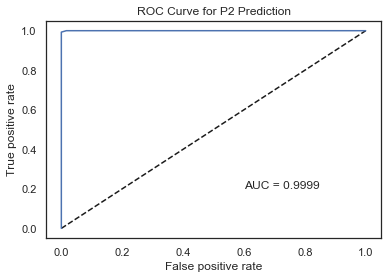

In [393]:
custom_test_function(P2_model_final, Xp_P2, yp_P2, proba=True, name="P2 Prediction")

In [378]:
yhat_P2 = P2_model_final.predict(Xp_P2)
print("Best AUC score for predictor-II : ", P2_model_final.score(Xp_P2, yp_P2))

Best AUC score for predictor-II :  0.995


In [ ]:
# df_pred_final.P2 = your prediction

For all remaining problems, you may use any or all of the features.

## Prediction P3

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price.


In [ ]:
# df_pred_final.P3 = your prediction

## Prediction P4

    Predict whether the closing price at the end of the first day of trading will go up by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

In [ ]:
# df_pred_final.P4 = your prediction

## Prediction P5

    Predict whether the closing price at the end of the first day of trading will go down by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).


In [ ]:
# df_pred_final.P5 = your prediction

## Prediction P6

    Predict the share price at the end of the first day.


In [ ]:
# df_pred_final.P6 = your prediction

For the remaining problems, provide a predicted probability (expressed as a number from 0 to 100) that the stated event will happen.
## Prediction P7

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 5% from the original offer price.

Scoring Metric for P7: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score of p * p (i.e., the square of your predicted probability for that event) will be assessed. For predictions where the event turns out to be TRUE, a score of (100 - p) * (100 - p) will be assessed (i.e., the square of 100 minus your predicted probability for that event). Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, then the score for that observation would equal 4,900 (70 * 70 = 4,900); but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 900 (100 - 70 = 30, and 30 * 30 = 900).

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P7 = your prediction

## Prediction P8

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 50% from the original offer price.

Scoring Metric for P8: Same scoring metric as P7 above. Attempt to tune you prediction model(s) accordingly.

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P8 = your prediction

## Prediction P9

    Predict the probability that the closing price at the end of the first day of trading will go down (the "positive" case, coded as 1) or not (coded as 0) by more than 10% from the original offer price.

Scoring Metric for P9: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score equal to p will be assessed. For predictions where the event turns out to be TRUE, a score of 2 * (100 - p) will be assessed. Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, the score for that observation would equal 70; but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 2 * (100 - 70) = 60.

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P9 = your prediction

In [172]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_P1, y_P1, test_size=0.2,  random_state=SEED)

In [225]:
random_model.fit(X_train, y_train)
print("Best parameter (CV score - roc_auc=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best parameter (CV score - roc_auc=0.692):
{'model__C': 2, 'pca__n_components': 32}


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s finished


In [207]:
search_results = pd.DataFrame(random_model.cv_results_).filter(regex=("(test_score|train_score)"))
search_results

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.5,0.5,0.5,0.5,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.0


In [224]:
# Plot a validation curve across levels of C, using a logscale for the x axis
#plot_validation_curve(search_results.mean_train_score.values, search_results.mean_train_score.values, range(len(search_results.mean_train_score.values)), x_logscale=False)

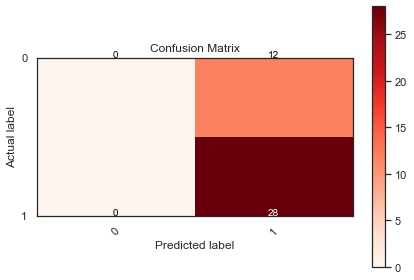

Accuracy   = 0.7000


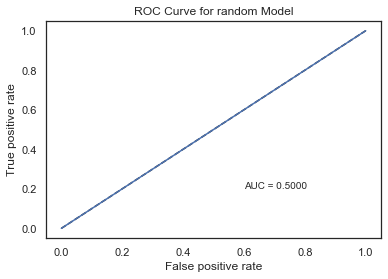

In [221]:
y_hat_random = random_model.predict(X_test)
cm_random = confusion_matrix(y_test, y_hat_random)  
plot_confusion_matrix(cm_random)
plt.show()

# Calculate accuracy
accuracy_random = 1 - ((cm_random[0][1] + cm_random[1][0])/(cm_random[0][1] + cm_random[1][0] + cm_random[1][1] + cm_random[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_random))

#plot roc curve
fpr_logit_random, tpr_logit_random, _ = roc_curve(y_test, y_hat_random)
best_auc_random = roc_auc_score(y_test, y_hat_random)
plot_roc(fpr_logit_random, tpr_logit_random, 'ROC Curve for random Model', 'AUC = %2.4f' % best_auc_random)